# Context-Aware Alpha Extraction (CAAE) Strategy - Quantitative Investing Final Project

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import zscore
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import matplotlib.pyplot as plt
from google.colab import drive
import seaborn as sns
from pandas.tseries.offsets import MonthEnd
from datetime import datetime

## Section 1: Defining the Goal and Strategy

### Factors

We decided to include the following factors, divided in categories like in the Factor Momentum paper:

- **Core Factor Portfolios**

  - *Value Portfolio:*

    Factors:
    Book-to-Market Ratio (B/M).
    Enterprise Multiple (EV/EBITDA).
    Rationale: Identifies undervalued stocks based on fundamentals.
  
  - *Momentum Portfolio:*

    Factors:
    6–12 Month Returns (medium-term momentum).
    Long-Term Reversals (12–24 months, captures trend exhaustion).
    Rationale: Leverages the tendency of recent winners to continue outperforming.
  
  - *Size Portfolio:*

    Factors:
    Market Capitalization (focus on smaller firms for the size effect).
    Rationale: Captures the tendency of smaller firms to outperform over time.
  
  - *Quality Portfolio:*

    Factors:
    Quality Minus Junk (QMJ, combines financial health metrics).
    Earnings-to-Price Ratio.
    Rationale: Targets financially healthy firms with stable earnings.
  
- **Profitability Factor Portfolio**

  - *Profitability Portfolio:*

    Factors:
    Gross Profitability.
    Return on Assets (ROA).
    Return on Equity (ROE).
    Profit Margin.
    Rationale: High profitability is associated with stronger long-term performance.
  
- **Earnings Quality Factor Portfolio**
  
  - *Earnings Quality Portfolio:*

    Factors:
    Accruals (lower accruals indicate higher earnings quality).
    Net Operating Assets.
    Cash-Flow-to-Price Ratio.
    Rationale: Companies with cleaner, more transparent earnings tend to outperform.

- **Investment and Growth Factor Portfolio**
  
  - *Investment & Growth Portfolio:*

    Factors:
    Asset Growth.
    CAPX Growth Rate.
    Sustainable Growth.
    Rationale: Targets firms with disciplined and sustainable growth trajectories.

- **Financing and Leverage Factor Portfolio**
  
  - *Financing & Leverage Portfolio:*

    Factors:
    Debt Issuance.
    One-Year Share Issuance.
    Five-Year Share Issuance.
    Rationale: High debt or share issuance can signal financial distress.

- **Non-Fundamental Factor Portfolio**
  
  - *Liquidity Portfolio:*

    Factors:
    Amihud’s Illiquidity (captures price impact of trading volume).
    High-Volume Premium.
    Rationale: Measures how liquidity impacts asset prices.

- **Macroeconomic-Related Factor Portfolio**
  
  - *Macro Sensitivity Portfolio:*

    Factors:
    Interest Rates.
    Inflation.
    VIX (Volatility Index).
    Rationale: Captures sensitivity to macroeconomic variables.
  
- **Past Returns Factor Portfolio**
  
  - *Past Returns Portfolio:*

    Factors:
    1-Month Lagged Returns.
    2–5 Month Lagged Returns.
    6–12 Month Returns.
    12–24 Month Returns.
    Rationale: Examines how past returns predict future performance.

- **Other Considerations**
  - *Distress Risk Portfolio:*

    Factors:
    Ohlson’s O-Score.
    Altman’s Z-Score.
    Low Beta.
    Piotroski’s F-Score.
    Rationale: Focuses on distress risk and financially stable firms.

## Section 2 - Preparing the Data

This is the Datasets we are using in this research, downloaded from WRDS, BLS and saved as csv files:

- **WRDS - CRSP Monthly Stock File (crsp_monthly):**

  Purpose: Provides price data, returns, market cap, and delisting information.

- **WRDS - CRSP Stock-Security Link (crsp_msenames):**

  Purpose: Links CRSP identifiers (PERMNO) to CUSIP, NCUSIP, or ticker symbols, enabling merging with Compustat data.

- **WRDS - Compustat Fundamentals Annual and Quarterly (comp_annual, comp_quarterly):**

  Purpose: Provides fundamental financial data, including assets, equity, income, sales, and capital expenditures, used to calculate Book-to-Market, ROA, ROE, and other factors.

- **WRDS - Fama-French Factors (ff_all):**

  Purpose: Includes Market Risk Premium, SMB (Size), HML (Value), and other factors for benchmarking and regression analysis.

- **BLS - Monthly Inflation and 3-Month TBill rates:**

  Purpose: Provides macroeconomic data such as inflation and interest rates for classifying market regimes.

- **VIX Index (cboe_all):**

  Purpose: Measures market volatility to assist in market regime classification.

- **Linking Table (wrdsapps_link_crsp_comp_bdx):**

  Purpose: Links CRSP PERMNO to Compustat GVKEY, enabling integration of market and fundamental data.

### Fetching and Inspecting the Data

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

# Define folder path
folder_path = '/content/drive/My Drive/Quant Research Data/'

Mounted at /content/drive


In [3]:
# Load files into DataFrames
comp_annual = pd.read_csv(folder_path + 'comp_annual.csv')
comp_quarterly = pd.read_csv(folder_path + 'comp_quarterly.csv')
crsp_monthly = pd.read_csv(folder_path + 'crsp_monthly.csv')
crsp_daily = pd.read_csv(folder_path + 'crsp_daily.csv')
crsp_msenames = pd.read_csv(folder_path + 'crsp_msenames.csv')
ff_monthly = pd.read_csv(folder_path + 'ff_monthly.csv')
infl = pd.read_csv(folder_path + 'CPIAUCSL.csv')
ir = pd.read_csv(folder_path + 'TB3MS.csv')

# Convert files to DataFrames
comp_annual_df = pd.DataFrame(comp_annual)
comp_quarterly_df = pd.DataFrame(comp_quarterly)
crsp_monthly_df = pd.DataFrame(crsp_monthly)
crsp_daily_df = pd.DataFrame(crsp_daily)
crsp_names_df = pd.DataFrame(crsp_msenames)
ff_monthly_df = pd.DataFrame(ff_monthly)
infl_df = pd.DataFrame(infl)
ir_df = pd.DataFrame(ir)

In [30]:
comp_annual_df.head()

,Unnamed: 0,gvkey,datadate,fyear,at,ceq,ib,sale,capx,seq,dvt,lt
0,0,1004,2000-05-31,1999.0,740.998,339.515,35.163,1024.333,22.344,339.515,9.218,401.483
1,1,1004,2001-05-31,2000.0,701.854,340.212,18.531,874.255,13.134,340.212,9.157,361.642
2,2,1004,2001-05-31,2000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1004,2002-05-31,2001.0,710.199,310.235,-58.939,638.721,12.112,310.235,4.430,399.964
4,4,1004,2002-05-31,2001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
comp_quarterly_df.head()

,Unnamed: 0,gvkey,datadate,fyearq,fqtr,atq,ceqq,ibq,saleq,capxy,seqq,dvpq,ltq
0,0,1013,2000-01-31,2000,1.0,1814.519,1396.005,53.100,593.900,46.785,1396.005,0.0,418.514
1,1,1082,2000-01-31,1999,3.0,110.675,21.270,-0.216,30.087,9.597,21.270,0.0,89.405
2,2,1173,2000-01-31,1999,4.0,22.774,12.644,-0.001,6.279,0.558,12.644,0.0,10.130
3,3,1183,2000-01-31,1999,4.0,103.962,83.879,-4.053,2.031,1.091,83.879,0.0,20.083
4,4,1189,2000-01-31,2000,2.0,839.170,363.297,5.689,335.768,17.181,363.297,0.0,470.366


In [32]:
crsp_monthly_df.head()

,Unnamed: 0,permno,permco,date,prc,vol,ret,retx,shrout
0,0,10001,7953,2000-01-31,8.125,403.0,-0.044118,-0.044118,2450.0
1,1,10002,7954,2000-01-31,11.875,567.0,-0.025641,-0.025641,7729.0
2,2,10009,7965,2000-01-31,14.625,455.0,-0.008475,-0.008475,2307.0
3,3,10012,7969,2000-01-31,7.250,62368.0,-0.097276,-0.097276,19274.0
4,4,10016,1728,2000-01-31,17.000,10387.0,-0.099338,-0.099338,17869.0


In [33]:
crsp_daily_df.head()

,Unnamed: 0,permno,date,prc,vol,ret
0,0,10001,2000-01-03,8.5625,1721.0,0.007353
1,1,10002,2000-01-03,12.0000,850.0,-0.015385
2,2,10009,2000-01-03,16.7500,8290.0,0.135593
3,3,10012,2000-01-03,8.0000,272796.0,-0.003891
4,4,10016,2000-01-03,19.6250,9432.0,0.039735


In [34]:
print(comp_annual_df.columns)
print(crsp_monthly_df.columns)
print(crsp_names_df.columns)
print(ff_monthly_df.columns)
print(infl_df.columns)

Index(['Unnamed: 0', 'gvkey', 'datadate', 'fyear', 'at', 'ceq', 'ib', 'sale',
       'capx', 'seq', 'dvt', 'lt'],
      dtype='object')
Index(['Unnamed: 0', 'permno', 'permco', 'date', 'prc', 'vol', 'ret', 'retx',
       'shrout'],
      dtype='object')
Index(['Unnamed: 0', 'permno', 'namedt', 'nameendt', 'ncusip', 'ticker',
       'comnam', 'shrcd', 'exchcd'],
      dtype='object')
Index(['Unnamed: 0', 'date', 'mktrf', 'smb', 'hml', 'rf', 'year', 'month',
       'umd', 'dateff'],
      dtype='object')
Index(['DATE', 'CPIAUCSL', 'date'], dtype='object')


In [35]:
crsp_names_df.head()

,Unnamed: 0,permno,namedt,nameendt,ncusip,ticker,comnam,shrcd,exchcd
0,0,10000,1986-01-07,1986-12-03,68391610,OMFGA,OPTIMUM MANUFACTURING INC,10,3
1,1,10000,1986-12-04,1987-03-09,68391610,OMFGA,OPTIMUM MANUFACTURING INC,10,3
2,2,10000,1987-03-10,1987-06-11,68391610,OMFGA,OPTIMUM MANUFACTURING INC,10,3
3,3,10001,1986-01-09,1993-11-21,39040610,GFGC,GREAT FALLS GAS CO,11,3
4,4,10001,1993-11-22,2004-06-09,29274A10,EWST,ENERGY WEST INC,11,3


In [36]:
ff_monthly_df.head()

,Unnamed: 0,date,mktrf,smb,hml,rf,year,month,umd,dateff
0,0,2000-01-01,-0.0474,0.0577,-0.0188,0.0041,2000.0,1.0,0.0192,2000-01-31
1,1,2000-02-01,0.0245,0.2136,-0.0959,0.0043,2000.0,2.0,0.1820,2000-02-29
2,2,2000-03-01,0.0520,-0.1720,0.0813,0.0047,2000.0,3.0,-0.0683,2000-03-31
3,3,2000-04-01,-0.0640,-0.0668,0.0726,0.0046,2000.0,4.0,-0.0839,2000-04-28
4,4,2000-05-01,-0.0442,-0.0605,0.0475,0.0050,2000.0,5.0,-0.0898,2000-05-31


In [37]:
infl_df

,DATE,CPIAUCSL,date
0,1947-01-31,21.480,1947-01-31
1,1947-02-28,21.620,1947-02-28
2,1947-03-31,22.000,1947-03-31
3,1947-04-30,22.000,1947-04-30
4,1947-05-31,21.950,1947-05-31
...,...,...,...
929,2024-06-30,313.049,2024-06-30
930,2024-07-31,313.534,2024-07-31
931,2024-08-31,314.121,2024-08-31
932,2024-09-30,314.686,2024-09-30


In [38]:
ir_df

,DATE,TB3MS,IR,date
0,1934-01-31,0.72,0.0072,1934-01-31
1,1934-02-28,0.62,0.0062,1934-02-28
2,1934-03-31,0.24,0.0024,1934-03-31
3,1934-04-30,0.15,0.0015,1934-04-30
4,1934-05-31,0.16,0.0016,1934-05-31
...,...,...,...,...
1085,2024-06-30,5.24,0.0524,2024-06-30
1086,2024-07-31,5.20,0.0520,2024-07-31
1087,2024-08-31,5.05,0.0505,2024-08-31
1088,2024-09-30,4.72,0.0472,2024-09-30


### Processing and Cleaning the Data

#### Compustat

We fetched the annual and quarterly Compustat datasets from WRDS and now we clean the columns to ensure proper formatting, and we create a monthly Compustat dataset by filling missing values, in order to merge with the monthly Crsp dataset.

In [39]:
comp_annual_df.head()

,Unnamed: 0,gvkey,datadate,fyear,at,ceq,ib,sale,capx,seq,dvt,lt
0,0,1004,2000-05-31,1999.0,740.998,339.515,35.163,1024.333,22.344,339.515,9.218,401.483
1,1,1004,2001-05-31,2000.0,701.854,340.212,18.531,874.255,13.134,340.212,9.157,361.642
2,2,1004,2001-05-31,2000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1004,2002-05-31,2001.0,710.199,310.235,-58.939,638.721,12.112,310.235,4.430,399.964
4,4,1004,2002-05-31,2001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# Drop columns before 'gvkey'
comp_annual_df = comp_annual_df.loc[:, 'gvkey':]

comp_annual_df.head()

,gvkey,datadate,fyear,at,ceq,ib,sale,capx,seq,dvt,lt
0,1004,2000-05-31,1999.0,740.998,339.515,35.163,1024.333,22.344,339.515,9.218,401.483
1,1004,2001-05-31,2000.0,701.854,340.212,18.531,874.255,13.134,340.212,9.157,361.642
2,1004,2001-05-31,2000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1004,2002-05-31,2001.0,710.199,310.235,-58.939,638.721,12.112,310.235,4.430,399.964
4,1004,2002-05-31,2001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# Drop columns before 'gvkey'
comp_quarterly_df = comp_quarterly_df.loc[:, 'gvkey':]

comp_quarterly_df.head()

,gvkey,datadate,fyearq,fqtr,atq,ceqq,ibq,saleq,capxy,seqq,dvpq,ltq
0,1013,2000-01-31,2000,1.0,1814.519,1396.005,53.100,593.900,46.785,1396.005,0.0,418.514
1,1082,2000-01-31,1999,3.0,110.675,21.270,-0.216,30.087,9.597,21.270,0.0,89.405
2,1173,2000-01-31,1999,4.0,22.774,12.644,-0.001,6.279,0.558,12.644,0.0,10.130
3,1183,2000-01-31,1999,4.0,103.962,83.879,-4.053,2.031,1.091,83.879,0.0,20.083
4,1189,2000-01-31,2000,2.0,839.170,363.297,5.689,335.768,17.181,363.297,0.0,470.366


In [42]:
comp_quarterly_df

,gvkey,datadate,fyearq,fqtr,atq,ceqq,ibq,saleq,capxy,seqq,dvpq,ltq
0,1013,2000-01-31,2000,1.0,1814.519,1396.005,53.100,593.900,46.785,1396.005,0.0,418.514
1,1082,2000-01-31,1999,3.0,110.675,21.270,-0.216,30.087,9.597,21.270,0.0,89.405
2,1173,2000-01-31,1999,4.0,22.774,12.644,-0.001,6.279,0.558,12.644,0.0,10.130
3,1183,2000-01-31,1999,4.0,103.962,83.879,-4.053,2.031,1.091,83.879,0.0,20.083
4,1189,2000-01-31,2000,2.0,839.170,363.297,5.689,335.768,17.181,363.297,0.0,470.366
...,...,...,...,...,...,...,...,...,...,...,...,...
1143810,179400,2024-10-31,2024,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1143811,260849,2024-10-31,2024,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1143812,260850,2024-10-31,2024,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1143813,264645,2024-10-31,2024,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# Converting Quarterly Compustat Data into Monthly Data

# Ensure 'datadate' in comp_quarterly_df is in datetime format
comp_quarterly_df['datadate'] = pd.to_datetime(comp_quarterly_df['datadate'])

# Define the full monthly date range for all gvkeys
start_date = '2000-01-31'  # Start of the desired date range
end_date = '2024-10-31'    # End of the desired date range
full_date_range = pd.date_range(start=start_date, end=end_date, freq="M")

# Initialize a list to collect dataframes
monthly_data = []

# Iterate over each gvkey group
for gvkey, group in comp_quarterly_df.groupby("gvkey"):
    # Create a complete monthly DataFrame for the gvkey
    monthly_df = pd.DataFrame({"datadate": full_date_range})
    monthly_df["gvkey"] = gvkey

    # Merge the full monthly range with the gvkey's original quarterly data
    merged = monthly_df.merge(group, on=["gvkey", "datadate"], how="left")

    # Forward fill missing values starting from the first available data
    merged = merged.sort_values("datadate").ffill()

    # Append to the list
    monthly_data.append(merged)

# Combine all gvkey data into a single DataFrame
compustat_quarttomonthly_df = pd.concat(monthly_data).reset_index(drop=True)

# Inspect the resulting dataframe
compustat_quarttomonthly_df

<ipython-input-43-aa4e72cb9976>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  full_date_range = pd.date_range(start=start_date, end=end_date, freq="M")


,datadate,gvkey,fyearq,fqtr,atq,ceqq,ibq,saleq,capxy,seqq,dvpq,ltq
0,2000-01-31,1004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-02-29,1004,1999.0,3.0,753.755,342.482,10.955,272.331,17.574,342.482,0.0,411.273
2,2000-03-31,1004,1999.0,3.0,753.755,342.482,10.955,272.331,17.574,342.482,0.0,411.273
3,2000-04-30,1004,1999.0,3.0,753.755,342.482,10.955,272.331,17.574,342.482,0.0,411.273
4,2000-05-31,1004,1999.0,4.0,740.998,339.515,2.471,225.079,22.344,339.515,0.0,401.483
...,...,...,...,...,...,...,...,...,...,...,...,...
9592657,2024-06-30,356687,2024.0,2.0,215.965,209.337,-1.809,0.000,15.497,209.337,0.0,6.628
9592658,2024-07-31,356687,2024.0,2.0,215.965,209.337,-1.809,0.000,15.497,209.337,0.0,6.628
9592659,2024-08-31,356687,2024.0,2.0,215.965,209.337,-1.809,0.000,15.497,209.337,0.0,6.628
9592660,2024-09-30,356687,2024.0,2.0,215.965,209.337,-1.809,0.000,15.497,209.337,0.0,6.628


In [44]:
# Checking if all gvkeys have full range of dates, even though some may have NaaN values due to the first quarterly data avilable not being in January 2000

# Define the full date range
full_date_range = pd.date_range(start='2000-01-31', end='2024-10-31', freq='M')

# Group by gvkey and find missing dates
missing_dates = compustat_quarttomonthly_df.groupby('gvkey')['datadate'].apply(
    lambda x: full_date_range.difference(pd.to_datetime(x))
).reset_index(name='missing_dates')

# Filter gvkeys with missing dates
gvkeys_with_missing = missing_dates[missing_dates['missing_dates'].str.len() > 0]

# Output the count and details of gvkeys with missing dates
print(f"Total gvkeys with missing dates: {len(gvkeys_with_missing)}")
if not gvkeys_with_missing.empty:
    print("Sample of gvkeys with missing dates:")
    print(gvkeys_with_missing.head())


<ipython-input-44-8e581eb97885>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  full_date_range = pd.date_range(start='2000-01-31', end='2024-10-31', freq='M')


Total gvkeys with missing dates: 0


In [45]:
compustat_quarttomonthly_df.to_csv('compustat_monthly_accurate.csv', index=False)
print("Processed Compustat data saved to 'compustat_quarterly_accurate.csv'")

Processed Compustat data saved to 'compustat_quarterly_accurate.csv'


#### CRSP

We fetched CRSP monthly data from WRDS and we now clean the columns to ensure proper formatting

In [46]:
crsp_monthly_df

,Unnamed: 0,permno,permco,date,prc,vol,ret,retx,shrout
0,0,10001,7953,2000-01-31,8.125,403.0,-0.044118,-0.044118,2450.0
1,1,10002,7954,2000-01-31,11.875,567.0,-0.025641,-0.025641,7729.0
2,2,10009,7965,2000-01-31,14.625,455.0,-0.008475,-0.008475,2307.0
3,3,10012,7969,2000-01-31,7.250,62368.0,-0.097276,-0.097276,19274.0
4,4,10016,1728,2000-01-31,17.000,10387.0,-0.099338,-0.099338,17869.0
...,...,...,...,...,...,...,...,...,...
2168035,168035,93426,53443,2023-12-29,34.070,17816.0,0.117416,0.117416,12510.0
2168036,168036,93427,53445,2023-12-29,190.330,64881.0,0.175602,0.175602,36331.0
2168037,168037,93429,53447,2023-12-29,178.560,176815.0,-0.019924,-0.019924,105556.0
2168038,168038,93434,53427,2023-12-29,0.700,25471.0,0.065449,0.065449,43039.0


In [47]:
# Drop columns before 'permno'
crsp_monthly_df = crsp_monthly_df.loc[:, 'permno':]

# Set date to datetime
crsp_monthly_df['date'] = pd.to_datetime(crsp_monthly_df['date'])

# Set date to end of the month
crsp_monthly_df['date'] = crsp_monthly_df['date'] + MonthEnd(0)

# Drop unnecessary columns
essential_columns = [
    'permno', 'date', 'prc', 'vol', 'ret', 'shrout', 'retx'
]
crsp_monthly_df = crsp_monthly_df[essential_columns]

crsp_monthly_df.head()

,permno,date,prc,vol,ret,shrout,retx
0,10001,2000-01-31,8.125,403.0,-0.044118,2450.0,-0.044118
1,10002,2000-01-31,11.875,567.0,-0.025641,7729.0,-0.025641
2,10009,2000-01-31,14.625,455.0,-0.008475,2307.0,-0.008475
3,10012,2000-01-31,7.250,62368.0,-0.097276,19274.0,-0.097276
4,10016,2000-01-31,17.000,10387.0,-0.099338,17869.0,-0.099338


In [48]:
# Checking if all permnos in CRSP have full range of dates

# Define the full date range
full_date_range = pd.date_range(start='2000-01-31', end='2023-12-29', freq='M')

# Group by gvkey and find missing dates
missing_dates = crsp_monthly_df.groupby('permno')['date'].apply(
    lambda x: full_date_range.difference(pd.to_datetime(x))
).reset_index(name='missing_dates')

# Filter gvkeys with missing dates
permnos_with_missing = missing_dates[missing_dates['missing_dates'].str.len() > 0]

# Output the count and details of gvkeys with missing dates
print(f"Total permnos with missing dates: {len(permnos_with_missing)}")
if not permnos_with_missing.empty:
    print("Sample of permnos with missing dates:")
    print(permnos_with_missing.head())

<ipython-input-48-2b69e37e6fca>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  full_date_range = pd.date_range(start='2000-01-31', end='2023-12-29', freq='M')


Total permnos with missing dates: 20737
Sample of permnos with missing dates:
   permno                                      missing_dates
0   10001  DatetimeIndex(['2017-09-30', '2017-10-31', '20...
1   10002  DatetimeIndex(['2013-03-31', '2013-04-30', '20...
2   10009  DatetimeIndex(['2000-12-31', '2001-01-31', '20...
3   10012  DatetimeIndex(['2005-09-30', '2005-10-31', '20...
4   10016  DatetimeIndex(['2001-06-30', '2001-07-31', '20...


There are multiple permnos with missing dates, showing that WRDS CRSP monthly is not entirely complete. This will come into play in the merging of the CRSP and Compustat data, we will make sure that the merging happens only on available dates for both the datasets.

#### Inflation

We fetched the Seasonally Adjusted CPI data from BLS and we now calculate the monthly inflation rates by computing the monthly percentage change in CPI.

In [49]:
# Ensure the DATE column is in datetime format and sort by date
infl_df['DATE'] = pd.to_datetime(infl_df['DATE'])
infl_df.sort_values('DATE', inplace=True)

# Calculate the monthly inflation rate
infl_df['InflationRate'] = infl_df['CPIAUCSL'].pct_change()

# Drop the first row with NaN due to pct_change()
infl_df.dropna(subset=['InflationRate'], inplace=True)

# Save the processed dataset
infl_df.to_csv('inflation_monthly.csv', index=False)
print("Processed CPI data with inflation rate saved to 'inflation_monthly.csv'")

Processed CPI data with inflation rate saved to 'inflation_monthly.csv'


In [50]:
infl = pd.read_csv('inflation_monthly.csv')
infl_df = pd.DataFrame(infl)

infl_df

,DATE,CPIAUCSL,date,InflationRate
0,1947-02-28,21.620,1947-02-28,0.006518
1,1947-03-31,22.000,1947-03-31,0.017576
2,1947-04-30,22.000,1947-04-30,0.000000
3,1947-05-31,21.950,1947-05-31,-0.002273
4,1947-06-30,22.080,1947-06-30,0.005923
...,...,...,...,...
928,2024-06-30,313.049,2024-06-30,-0.000562
929,2024-07-31,313.534,2024-07-31,0.001549
930,2024-08-31,314.121,2024-08-31,0.001872
931,2024-09-30,314.686,2024-09-30,0.001799


In [ ]:
# Plot inflation



#### 3-Month Treasure Bill Rates (Monthly)

We fetched the 3-Month Treasury Bill Secondary Market Rate, Discount Basis data from BLS and we now calculate the values in decimals.

In [51]:
ir_df['IR'] = ir_df['TB3MS']/ 100

ir_df

,DATE,TB3MS,IR,date
0,1934-01-31,0.72,0.0072,1934-01-31
1,1934-02-28,0.62,0.0062,1934-02-28
2,1934-03-31,0.24,0.0024,1934-03-31
3,1934-04-30,0.15,0.0015,1934-04-30
4,1934-05-31,0.16,0.0016,1934-05-31
...,...,...,...,...
1085,2024-06-30,5.24,0.0524,2024-06-30
1086,2024-07-31,5.20,0.0520,2024-07-31
1087,2024-08-31,5.05,0.0505,2024-08-31
1088,2024-09-30,4.72,0.0472,2024-09-30


In [52]:
# Save the processed dataset
ir_df.to_csv('ir_monthly.csv', index=False)
print("Processed 3-Month TBill data with inflation rate saved to 'ir_monthly.csv'")

Processed 3-Month TBill data with inflation rate saved to 'ir_monthly.csv'


#### VIX

In [15]:
import yfinance as yf

# Fetch VIX data
vix_data = yf.download("^VIX", start="2000-05-01", end="2023-12-01", interval="1mo")
vix_data.reset_index(inplace=True)

# Ensure the date is set to MonthEnd
vix_data['Date'] = pd.to_datetime(vix_data['Date']) + pd.offsets.MonthEnd(0)

# Select only the required columns and rename for clarity
vix_data = vix_data[['Date', 'Adj Close']].rename(columns={'Adj Close': 'VIX'})

[*********************100%***********************]  1 of 1 completed


In [17]:
# Reset index to drop the Ticker level
vix_df = vix_data.reset_index()

# Convert 'Date' to datetime, remove hourly time, and align to MonthEnd
vix_df['Date'] = pd.to_datetime(vix_df['Date']).dt.to_period('M').dt.to_timestamp('M')

# Keep only the relevant columns
vix_df = vix_df[['Date', 'VIX']]

vix_df

<ipython-input-17-7972b7763678>:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  vix_df['Date'] = pd.to_datetime(vix_df['Date']).dt.to_period('M').dt.to_timestamp('M')


Price,Date,VIX
Ticker,,^VIX
0,2000-05-31,23.650000
1,2000-06-30,19.540001
2,2000-07-31,20.740000
3,2000-08-31,16.840000
4,2000-09-30,20.570000
...,...,...
272,2023-01-31,19.400000
273,2023-02-28,20.700001
274,2023-03-31,18.700001


In [19]:
vix_df.to_csv('vix_monthly.csv', index=False)
print("Processed VIX data saved to 'vix_monthly.csv'")

Processed VIX data saved to 'vix_monthly.csv'


### Creating the Main Analysis Dataframe

#### Merging CRSP and Compustat through PERMNO and Gvkey Mapping

In [ ]:
# Fetching the Linking Table and the Compustat Monthly datasets
link_table = pd.read_csv(folder_path + 'link_table_crspcomp.csv')
compustat_monthly_accurate = pd.read_csv(folder_path + 'compustat_monthly_accurate.csv')

In [ ]:
compustat_monthly_accurate.head(20)

,datadate,gvkey,fyearq,fqtr,atq,ceqq,ibq,saleq,capxy,seqq,dvpq,ltq
0,2000-01-31,1004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-02-29,1004,1999.0,3.0,753.755,342.482,10.955,272.331,17.574,342.482,0.0,411.273
2,2000-03-31,1004,1999.0,3.0,753.755,342.482,10.955,272.331,17.574,342.482,0.0,411.273
3,2000-04-30,1004,1999.0,3.0,753.755,342.482,10.955,272.331,17.574,342.482,0.0,411.273
4,2000-05-31,1004,1999.0,4.0,740.998,339.515,2.471,225.079,22.344,339.515,0.0,401.483
5,2000-06-30,1004,1999.0,4.0,740.998,339.515,2.471,225.079,22.344,339.515,0.0,401.483
6,2000-07-31,1004,1999.0,4.0,740.998,339.515,2.471,225.079,22.344,339.515,0.0,401.483
7,2000-08-31,1004,2000.0,1.0,747.543,339.253,3.159,241.770,2.986,339.253,0.0,408.290
8,2000-09-30,1004,2000.0,1.0,747.543,339.253,3.159,241.770,2.986,339.253,0.0,408.290
9,2000-10-31,1004,2000.0,1.0,747.543,339.253,3.159,241.770,2.986,339.253,0.0,408.290


In [ ]:
link_table

,Unnamed: 0,lpermno,gvkey,linkdt,linkenddt,linktype
0,0,25881.0,1000,1970-11-13,1978-06-30,LU
1,1,10015.0,1001,1983-09-20,1986-07-31,LU
2,2,10023.0,1002,1972-12-14,1973-06-05,LC
3,3,10031.0,1003,1983-12-07,1989-08-16,LU
4,4,54594.0,1004,1972-04-24,NaN,LU
...,...,...,...,...,...,...
33001,33001,23514.0,349994,2022-11-15,NaN,LC
33002,33002,22205.0,350681,2021-10-22,2023-03-31,LC
33003,33003,16161.0,351038,2021-10-29,NaN,LC
33004,33004,23773.0,352262,2023-03-17,NaN,LC


In [ ]:
# Lagging the Compustat Data by 3 months to ensure no Look-ahead bias

# Ensure the DataFrame is sorted by gvkey and datadate before lagging
compustat_monthly_accurate = compustat_monthly_accurate.sort_values(by=['gvkey', 'datadate'])

# Columns to lag
compustat_cols = ['atq', 'ceqq', 'ibq', 'saleq', 'capxy', 'seqq', 'dvpq', 'ltq']

# Apply lagging grouped by gvkey
compustat_monthly_accurate[compustat_cols] = (
    compustat_monthly_accurate.groupby('gvkey')[compustat_cols]
    .shift(3)  # Lagging by 3 months
)

# Drop the first 3 rows for each gvkey to avoid lookahead bias
compustat_monthly_accurate = (
    compustat_monthly_accurate.groupby('gvkey', group_keys=False)
    .apply(lambda group: group.iloc[3:])
    .reset_index(drop=True)
)

# Verify the result
print(compustat_monthly_accurate.head())

<ipython-input-8-085ab8a01eae>:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.iloc[3:])


     datadate  gvkey  fyearq  fqtr      atq     ceqq     ibq    saleq   capxy  \
0  2000-04-30   1004  1999.0   3.0      NaN      NaN     NaN      NaN     NaN   
1  2000-05-31   1004  1999.0   4.0  753.755  342.482  10.955  272.331  17.574   
2  2000-06-30   1004  1999.0   4.0  753.755  342.482  10.955  272.331  17.574   
3  2000-07-31   1004  1999.0   4.0  753.755  342.482  10.955  272.331  17.574   
4  2000-08-31   1004  2000.0   1.0  740.998  339.515   2.471  225.079  22.344   

      seqq  dvpq      ltq  
0      NaN   NaN      NaN  
1  342.482   0.0  411.273  
2  342.482   0.0  411.273  
3  342.482   0.0  411.273  
4  339.515   0.0  401.483  


In [ ]:
compustat_monthly_accurate.head(40)

,datadate,gvkey,fyearq,fqtr,atq,ceqq,ibq,saleq,capxy,seqq,dvpq,ltq
0,2000-04-30,1004,1999.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-05-31,1004,1999.0,4.0,753.755,342.482,10.955,272.331,17.574,342.482,0.0,411.273
2,2000-06-30,1004,1999.0,4.0,753.755,342.482,10.955,272.331,17.574,342.482,0.0,411.273
3,2000-07-31,1004,1999.0,4.0,753.755,342.482,10.955,272.331,17.574,342.482,0.0,411.273
4,2000-08-31,1004,2000.0,1.0,740.998,339.515,2.471,225.079,22.344,339.515,0.0,401.483
5,2000-09-30,1004,2000.0,1.0,740.998,339.515,2.471,225.079,22.344,339.515,0.0,401.483
6,2000-10-31,1004,2000.0,1.0,740.998,339.515,2.471,225.079,22.344,339.515,0.0,401.483
7,2000-11-30,1004,2000.0,2.0,747.543,339.253,3.159,241.770,2.986,339.253,0.0,408.290
8,2000-12-31,1004,2000.0,2.0,747.543,339.253,3.159,241.770,2.986,339.253,0.0,408.290
9,2001-01-31,1004,2000.0,2.0,747.543,339.253,3.159,241.770,2.986,339.253,0.0,408.290


##### Merging the Datasets

In [ ]:
# Ensure date columns are in datetime format
link_table['linkdt'] = pd.to_datetime(link_table['linkdt'])
link_table['linkenddt'] = pd.to_datetime(link_table['linkenddt']).fillna(pd.Timestamp('2024-12-31'))  # Fill missing linkenddt
crsp_monthly_df['date'] = pd.to_datetime(crsp_monthly_df['date'])
compustat_monthly_accurate['datadate'] = pd.to_datetime(compustat_monthly_accurate['datadate'])

# Step 1: Merge CRSP with link_table
crsp_linked = crsp_monthly_df.merge(
    link_table,
    left_on='permno',
    right_on='lpermno',
    how='inner'
)

# Step 2: Filter CRSP-Compustat links based on link_table's linkdt and linkenddt
crsp_linked = crsp_linked[
    (crsp_linked['date'] >= crsp_linked['linkdt']) &
    (crsp_linked['date'] <= crsp_linked['linkenddt'])
]

# Step 3: Merge the filtered CRSP data with Compustat on gvkey and date
# Aligning Compustat monthly datadate to CRSP monthly date
merged = crsp_linked.merge(
    compustat_monthly_accurate,
    left_on=['gvkey', 'date'],
    right_on=['gvkey', 'datadate'],
    how='inner'  # Use 'inner' join to ensure matching dates in both datasets
)

# Step 4: Clean up unnecessary columns
final_merged = merged.drop(columns=['lpermno', 'linkdt', 'linkenddt', 'datadate'])

# Step 5: Sort by permno and date for clarity
final_merged = final_merged.sort_values(by=['permno', 'date']).reset_index(drop=True)

# Verify no unmatched dates
print("Unique permno-gvkey pairs:", final_merged.groupby(['permno', 'gvkey']).ngroups)
print("Total rows:", len(final_merged))

# Inspect the resulting dataframe
final_merged.head()

# Save to CSV if needed
# final_merged.to_csv("merged_crsp_compustat_monthly.csv", index=False)

Unique permno-gvkey pairs: 16907
Total rows: 1219963


,Unnamed: 0_x,permno,permco,date,prc,vol,ret,retx,shrout,Unnamed: 0_y,...,fyearq,fqtr,atq,ceqq,ibq,saleq,capxy,seqq,dvpq,ltq
0,34538,10001,7953,2000-05-31,-7.90625,221.0,-0.023166,-0.023166,2464.0,12039,...,2000.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,43175,10001,7953,2000-06-30,8.00000,350.0,0.027668,0.011858,2475.0,12039,...,2000.0,4.0,50.225,14.218,1.441,23.862,NaN,14.218,0.0,36.007
2,51829,10001,7953,2000-07-31,7.87500,560.0,-0.015625,-0.015625,2475.0,12039,...,2000.0,4.0,50.225,14.218,1.441,23.862,NaN,14.218,0.0,36.007
3,60478,10001,7953,2000-08-31,8.25000,1882.0,0.047619,0.047619,2475.0,12039,...,2000.0,4.0,50.225,14.218,1.441,23.862,NaN,14.218,0.0,36.007
4,77725,10001,7953,2000-10-31,9.00000,577.0,0.028571,0.028571,2496.0,12039,...,2001.0,1.0,50.553,13.961,-0.154,16.618,NaN,13.961,0.0,36.592


In [ ]:
final_merged

,Unnamed: 0_x,permno,permco,date,prc,vol,ret,retx,shrout,Unnamed: 0_y,...,fyearq,fqtr,atq,ceqq,ibq,saleq,capxy,seqq,dvpq,ltq
0,34538,10001,7953,2000-05-31,-7.90625,221.0,-0.023166,-0.023166,2464.0,12039,...,2000.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,43175,10001,7953,2000-06-30,8.00000,350.0,0.027668,0.011858,2475.0,12039,...,2000.0,4.0,50.225,14.218,1.441,23.862,NaN,14.218,0.0,36.007
2,51829,10001,7953,2000-07-31,7.87500,560.0,-0.015625,-0.015625,2475.0,12039,...,2000.0,4.0,50.225,14.218,1.441,23.862,NaN,14.218,0.0,36.007
3,60478,10001,7953,2000-08-31,8.25000,1882.0,0.047619,0.047619,2475.0,12039,...,2000.0,4.0,50.225,14.218,1.441,23.862,NaN,14.218,0.0,36.007
4,77725,10001,7953,2000-10-31,9.00000,577.0,0.028571,0.028571,2496.0,12039,...,2001.0,1.0,50.553,13.961,-0.154,16.618,NaN,13.961,0.0,36.592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219958,110802,93436,53453,2023-06-30,261.76999,34409322.0,0.283627,0.283627,3174000.0,32025,...,2023.0,2.0,86833.000,48054.000,2513.000,23329.000,2073.0,48054.000,0.0,37598.000
1219959,120300,93436,53453,2023-07-31,267.42999,23934292.0,0.021622,0.021622,3173994.0,32025,...,2023.0,2.0,86833.000,48054.000,2513.000,23329.000,2073.0,48054.000,0.0,37598.000
1219960,129824,93436,53453,2023-08-31,258.07999,25029170.0,-0.034962,-0.034962,3173994.0,32025,...,2023.0,2.0,86833.000,48054.000,2513.000,23329.000,2073.0,48054.000,0.0,37598.000
1219961,148976,93436,53453,2023-10-31,200.84000,25905681.0,-0.197346,-0.197346,3178921.0,32025,...,2023.0,3.0,90591.000,51130.000,2703.000,24927.000,4133.0,51130.000,0.0,38409.000


##### Cleaning the Merged Dataframe

In [ ]:
# Step 1: Retain only required columns
columns_to_keep = [
    'permno', 'date', 'prc', 'vol', 'ret', 'shrout', 'retx',  # CRSP fields
    'gvkey', 'atq', 'ceqq', 'ibq', 'saleq', 'capxy', 'seqq', 'dvpq', 'ltq'  # Compustat fields
]

# Drop unnecessary columns
cleaned_df = final_merged[columns_to_keep].copy()

# Step 2: Remove duplicate dates per permno
cleaned_df = cleaned_df.sort_values(by=['permno', 'date']).drop_duplicates(subset=['permno', 'date'], keep='first')

# Step 3: Handle potential missing or zero values for critical fields
# Example: Adjust prc and shrout for Market Value (MV) calculations
cleaned_df['prc'] = cleaned_df['prc'].abs()  # Ensure positive price values
cleaned_df['shrout'] = cleaned_df['shrout'].replace(0, pd.NA)  # Avoid division by zero errors

# Step 4: Ensure dates are properly sorted
cleaned_df = cleaned_df.sort_values(by=['permno', 'date']).reset_index(drop=True)

# Inspect the cleaned dataframe
cleaned_df

,permno,date,prc,vol,ret,shrout,retx,gvkey,atq,ceqq,ibq,saleq,capxy,seqq,dvpq,ltq
0,10001,2000-05-31,7.90625,221.0,-0.023166,2464.0,-0.023166,12994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10001,2000-06-30,8.00000,350.0,0.027668,2475.0,0.011858,12994,50.225,14.218,1.441,23.862,NaN,14.218,0.0,36.007
2,10001,2000-07-31,7.87500,560.0,-0.015625,2475.0,-0.015625,12994,50.225,14.218,1.441,23.862,NaN,14.218,0.0,36.007
3,10001,2000-08-31,8.25000,1882.0,0.047619,2475.0,0.047619,12994,50.225,14.218,1.441,23.862,NaN,14.218,0.0,36.007
4,10001,2000-10-31,9.00000,577.0,0.028571,2496.0,0.028571,12994,50.553,13.961,-0.154,16.618,NaN,13.961,0.0,36.592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219793,93436,2023-06-30,261.76999,34409322.0,0.283627,3174000.0,0.283627,184996,86833.000,48054.000,2513.000,23329.000,2073.0,48054.000,0.0,37598.000
1219794,93436,2023-07-31,267.42999,23934292.0,0.021622,3173994.0,0.021622,184996,86833.000,48054.000,2513.000,23329.000,2073.0,48054.000,0.0,37598.000
1219795,93436,2023-08-31,258.07999,25029170.0,-0.034962,3173994.0,-0.034962,184996,86833.000,48054.000,2513.000,23329.000,2073.0,48054.000,0.0,37598.000
1219796,93436,2023-10-31,200.84000,25905681.0,-0.197346,3178921.0,-0.197346,184996,90591.000,51130.000,2703.000,24927.000,4133.0,51130.000,0.0,38409.000


##### Final Cleaning: Ensure no duplicates and handling missing values

In [ ]:
cleaned_df = cleaned_df.drop_duplicates(subset=['permno', 'date']).reset_index(drop=True)

In [ ]:
missing_summary = cleaned_df.isna().sum() / len(cleaned_df) * 100
print(missing_summary)

permno     0.000000
date       0.000000
prc        0.654699
vol        0.339482
ret        1.150272
shrout     0.000820
retx       1.150272
gvkey      0.000000
atq        9.799163
ceqq       9.855402
ibq        9.735136
saleq      9.741531
capxy     12.464195
seqq       9.807771
dvpq       9.734071
ltq        9.801869
dtype: float64


Cleaned_df shows some missing values, which could be due company not reporting fully compustat variables. We decided to forward fill for missing CRSP data and to leave the missing values of compustat, as we do not know wether they come from a linking problem or from the companies not reporting them

In [ ]:
# Define the list of Compustat variables to check
compustat_variables = ['atq', 'ceqq', 'ibq', 'saleq', 'capxy', 'seqq', 'dvpq', 'ltq']

# Initialize a dictionary to store permnos with completely NaN variables
permno_nan_variables = {}

# Iterate over each variable to check for complete NaN series per permno
for var in compustat_variables:
    # Find permnos where the entire column is NaN for that variable
    nan_permnos = cleaned_df.groupby('permno')[var].apply(lambda x: x.isna().all())
    nan_permnos = nan_permnos[nan_permnos].index.tolist()  # Extract permnos with all NaN

    # Store the result if any permnos were found
    if nan_permnos:
        permno_nan_variables[var] = nan_permnos

# Convert the result to a DataFrame for better readability
nan_summary_df = (
    pd.DataFrame([(permno, var) for var, permnos in permno_nan_variables.items() for permno in permnos],
                 columns=['permno', 'variable'])
    .sort_values(by='permno')
)

# Display the result
print("Permnos with completely NaN Compustat variables:")
print(nan_summary_df)

# Save to CSV if needed
# nan_summary_df.to_csv("permnos_with_nan_compustat_variables.csv", index=False)


Permnos with completely NaN Compustat variables:
      permno variable
4228   10009    capxy
4229   10037    capxy
0      10065      atq
4230   10065    capxy
7744   10065      ltq
...      ...      ...
4227   93424    saleq
3188   93424      ibq
2151   93424     ceqq
7743   93424     dvpq
8815   93424      ltq

[8816 rows x 2 columns]


In [ ]:
# Sort the DataFrame by permno and date for proper forward-filling
cleaned_df = cleaned_df.sort_values(by=['permno', 'date'])

# Forward-fill the missing values within each permno group
crsp_cols_to_fill = ['prc', 'vol', 'ret', 'shrout', 'retx']  # Specify CRSP columns to fill
cleaned_df[crsp_cols_to_fill] = cleaned_df.groupby('permno')[crsp_cols_to_fill].ffill()

# Check for remaining missing values
missing_after_fill = cleaned_df[crsp_cols_to_fill].isna().sum()
print("Remaining missing values after forward-filling:")
print(missing_after_fill)

Remaining missing values after forward-filling:
prc       2038
vol       1971
ret       7831
shrout      10
retx      7831
dtype: int64


In [ ]:
cleaned_df

,permno,date,prc,vol,ret,shrout,retx,gvkey,atq,ceqq,ibq,saleq,capxy,seqq,dvpq,ltq
0,10001,2000-05-31,7.90625,221.0,-0.023166,2464.0,-0.023166,12994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10001,2000-06-30,8.00000,350.0,0.027668,2475.0,0.011858,12994,50.225,14.218,1.441,23.862,NaN,14.218,0.0,36.007
2,10001,2000-07-31,7.87500,560.0,-0.015625,2475.0,-0.015625,12994,50.225,14.218,1.441,23.862,NaN,14.218,0.0,36.007
3,10001,2000-08-31,8.25000,1882.0,0.047619,2475.0,0.047619,12994,50.225,14.218,1.441,23.862,NaN,14.218,0.0,36.007
4,10001,2000-10-31,9.00000,577.0,0.028571,2496.0,0.028571,12994,50.553,13.961,-0.154,16.618,NaN,13.961,0.0,36.592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219793,93436,2023-06-30,261.76999,34409322.0,0.283627,3174000.0,0.283627,184996,86833.000,48054.000,2513.000,23329.000,2073.0,48054.000,0.0,37598.000
1219794,93436,2023-07-31,267.42999,23934292.0,0.021622,3173994.0,0.021622,184996,86833.000,48054.000,2513.000,23329.000,2073.0,48054.000,0.0,37598.000
1219795,93436,2023-08-31,258.07999,25029170.0,-0.034962,3173994.0,-0.034962,184996,86833.000,48054.000,2513.000,23329.000,2073.0,48054.000,0.0,37598.000
1219796,93436,2023-10-31,200.84000,25905681.0,-0.197346,3178921.0,-0.197346,184996,90591.000,51130.000,2703.000,24927.000,4133.0,51130.000,0.0,38409.000


In [ ]:
# Check for multiple gvkeys per permno
ambiguous_mappings = link_table.groupby('lpermno')['gvkey'].nunique()
ambiguous_permnons = ambiguous_mappings[ambiguous_mappings > 1].index

# Inspect the problematic cases
ambiguous_rows = link_table[link_table['lpermno'].isin(ambiguous_permnons)]
print(ambiguous_rows.sort_values(by='lpermno'))

       Unnamed: 0  lpermno   gvkey     linkdt  linkenddt linktype
14303       14303  10051.0   16456 1989-08-14 2016-02-28       LC
12502       12502  10051.0   13445 1986-02-14 1989-04-28       LC
14302       14302  10051.0   16456 1989-04-29 1989-08-13       LC
14304       14304  10051.0   16456 2018-09-12 2022-10-31       LC
6739         6739  10057.0    7701 1967-01-31 1967-12-29       LC
...           ...      ...     ...        ...        ...      ...
31887       31887  93350.0  183850 2010-04-22 2021-05-19       LC
23256       23256  93350.0   38848 2021-05-20 2024-12-31       LC
21566       21566  93396.0   34133 2018-08-17 2018-08-31       LC
21567       21567  93396.0   34133 2018-09-01 2018-09-19       LC
31991       31991  93396.0  184680 2010-05-14 2018-08-16       LC

[1698 rows x 6 columns]


### Final Dataset with CRSP, Compustat, Inflation, Interest rates, and FF Factors

In [ ]:
infl_df.head()

,DATE,CPIAUCSL
0,1947-01-01,21.48
1,1947-02-01,21.62
2,1947-03-01,22.00
3,1947-04-01,22.00
4,1947-05-01,21.95


In [ ]:
ir_df.head()

,DATE,TB3MS
0,1934-01-01,0.72
1,1934-02-01,0.62
2,1934-03-01,0.24
3,1934-04-01,0.15
4,1934-05-01,0.16


In [ ]:
ff_monthly_df.head()

,Unnamed: 0,date,mktrf,smb,hml,rf,year,month,umd,dateff
0,0,2000-01-01,-0.0474,0.0577,-0.0188,0.0041,2000.0,1.0,0.0192,2000-01-31
1,1,2000-02-01,0.0245,0.2136,-0.0959,0.0043,2000.0,2.0,0.1820,2000-02-29
2,2,2000-03-01,0.0520,-0.1720,0.0813,0.0047,2000.0,3.0,-0.0683,2000-03-31
3,3,2000-04-01,-0.0640,-0.0668,0.0726,0.0046,2000.0,4.0,-0.0839,2000-04-28
4,4,2000-05-01,-0.0442,-0.0605,0.0475,0.0050,2000.0,5.0,-0.0898,2000-05-31


In [ ]:
# Ensure date columns are in datetime format for all dataframes
cleaned_df['date'] = pd.to_datetime(cleaned_df['date'])
infl_df['DATE'] = pd.to_datetime(infl_df['DATE'])+ MonthEnd(0)
ir_df['DATE'] = pd.to_datetime(ir_df['DATE'])+ MonthEnd(0)
ff_monthly_df['date'] = pd.to_datetime(ff_monthly_df['date'])+ MonthEnd(0)

# Merge inflation data
merged_df = cleaned_df.merge(infl_df[['DATE', 'InflationRate']], left_on='date', right_on='DATE', how='left')

merged_df

,permno,date,prc,vol,ret,shrout,retx,gvkey,atq,ceqq,ibq,saleq,capxy,seqq,dvpq,ltq,DATE,InflationRate
0,10001,2000-05-31,7.90625,221.0,-0.023166,2464.0,-0.023166,12994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-05-31,0.001755
1,10001,2000-06-30,8.00000,350.0,0.027668,2475.0,0.011858,12994,50.225,14.218,1.441,23.862,NaN,14.218,0.0,36.007,2000-06-30,0.005841
2,10001,2000-07-31,7.87500,560.0,-0.015625,2475.0,-0.015625,12994,50.225,14.218,1.441,23.862,NaN,14.218,0.0,36.007,2000-07-31,0.002904
3,10001,2000-08-31,8.25000,1882.0,0.047619,2475.0,0.047619,12994,50.225,14.218,1.441,23.862,NaN,14.218,0.0,36.007,2000-08-31,0.000000
4,10001,2000-10-31,9.00000,577.0,0.028571,2496.0,0.028571,12994,50.553,13.961,-0.154,16.618,NaN,13.961,0.0,36.592,2000-10-31,0.001728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219793,93436,2023-06-30,261.76999,34409322.0,0.283627,3174000.0,0.283627,184996,86833.000,48054.000,2513.000,23329.000,2073.0,48054.000,0.0,37598.000,2023-06-30,0.002103
1219794,93436,2023-07-31,267.42999,23934292.0,0.021622,3173994.0,0.021622,184996,86833.000,48054.000,2513.000,23329.000,2073.0,48054.000,0.0,37598.000,2023-07-31,0.002056
1219795,93436,2023-08-31,258.07999,25029170.0,-0.034962,3173994.0,-0.034962,184996,86833.000,48054.000,2513.000,23329.000,2073.0,48054.000,0.0,37598.000,2023-08-31,0.005118
1219796,93436,2023-10-31,200.84000,25905681.0,-0.197346,3178921.0,-0.197346,184996,90591.000,51130.000,2703.000,24927.000,4133.0,51130.000,0.0,38409.000,2023-10-31,0.000791


In [ ]:
# Merge interest rate data
merged_df = merged_df.merge(ir_df, left_on='date', right_on='DATE', how='left')
merged_df

,permno,date,prc,vol,ret,shrout,retx,gvkey,atq,ceqq,...,saleq,capxy,seqq,dvpq,ltq,DATE_x,InflationRate,DATE_y,TB3MS,IR
0,10001,2000-05-31,7.90625,221.0,-0.023166,2464.0,-0.023166,12994,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2000-05-31,0.001755,2000-05-31,5.79,0.0579
1,10001,2000-06-30,8.00000,350.0,0.027668,2475.0,0.011858,12994,50.225,14.218,...,23.862,NaN,14.218,0.0,36.007,2000-06-30,0.005841,2000-06-30,5.69,0.0569
2,10001,2000-07-31,7.87500,560.0,-0.015625,2475.0,-0.015625,12994,50.225,14.218,...,23.862,NaN,14.218,0.0,36.007,2000-07-31,0.002904,2000-07-31,5.96,0.0596
3,10001,2000-08-31,8.25000,1882.0,0.047619,2475.0,0.047619,12994,50.225,14.218,...,23.862,NaN,14.218,0.0,36.007,2000-08-31,0.000000,2000-08-31,6.09,0.0609
4,10001,2000-10-31,9.00000,577.0,0.028571,2496.0,0.028571,12994,50.553,13.961,...,16.618,NaN,13.961,0.0,36.592,2000-10-31,0.001728,2000-10-31,6.11,0.0611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219793,93436,2023-06-30,261.76999,34409322.0,0.283627,3174000.0,0.283627,184996,86833.000,48054.000,...,23329.000,2073.0,48054.000,0.0,37598.000,2023-06-30,0.002103,2023-06-30,5.16,0.0516
1219794,93436,2023-07-31,267.42999,23934292.0,0.021622,3173994.0,0.021622,184996,86833.000,48054.000,...,23329.000,2073.0,48054.000,0.0,37598.000,2023-07-31,0.002056,2023-07-31,5.25,0.0525
1219795,93436,2023-08-31,258.07999,25029170.0,-0.034962,3173994.0,-0.034962,184996,86833.000,48054.000,...,23329.000,2073.0,48054.000,0.0,37598.000,2023-08-31,0.005118,2023-08-31,5.30,0.0530
1219796,93436,2023-10-31,200.84000,25905681.0,-0.197346,3178921.0,-0.197346,184996,90591.000,51130.000,...,24927.000,4133.0,51130.000,0.0,38409.000,2023-10-31,0.000791,2023-10-31,5.34,0.0534


In [ ]:
# Merge Fama-French data
merged_df = merged_df.merge(ff_monthly_df, on='date', how='left')
merged_df

,permno,date,prc,vol,ret,shrout,retx,gvkey,atq,ceqq,...,IR,Unnamed: 0,mktrf,smb,hml,rf,year,month,umd,dateff
0,10001,2000-05-31,7.90625,221.0,-0.023166,2464.0,-0.023166,12994,NaN,NaN,...,0.0579,4,-0.0442,-0.0605,0.0475,0.0050,2000.0,5.0,-0.0898,2000-05-31
1,10001,2000-06-30,8.00000,350.0,0.027668,2475.0,0.011858,12994,50.225,14.218,...,0.0569,5,0.0464,0.1284,-0.0842,0.0040,2000.0,6.0,0.1660,2000-06-30
2,10001,2000-07-31,7.87500,560.0,-0.015625,2475.0,-0.015625,12994,50.225,14.218,...,0.0596,6,-0.0251,-0.0307,0.0831,0.0048,2000.0,7.0,-0.0005,2000-07-31
3,10001,2000-08-31,8.25000,1882.0,0.047619,2475.0,0.047619,12994,50.225,14.218,...,0.0609,7,0.0703,-0.0061,-0.0139,0.0050,2000.0,8.0,0.0573,2000-08-31
4,10001,2000-10-31,9.00000,577.0,0.028571,2496.0,0.028571,12994,50.553,13.961,...,0.0611,9,-0.0276,-0.0388,0.0571,0.0056,2000.0,10.0,-0.0448,2000-10-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219793,93436,2023-06-30,261.76999,34409322.0,0.283627,3174000.0,0.283627,184996,86833.000,48054.000,...,0.0516,281,0.0647,0.0155,-0.0020,0.0040,2023.0,6.0,-0.0235,2023-06-30
1219794,93436,2023-07-31,267.42999,23934292.0,0.021622,3173994.0,0.021622,184996,86833.000,48054.000,...,0.0525,282,0.0321,0.0205,0.0411,0.0045,2023.0,7.0,-0.0405,2023-07-31
1219795,93436,2023-08-31,258.07999,25029170.0,-0.034962,3173994.0,-0.034962,184996,86833.000,48054.000,...,0.0530,283,-0.0239,-0.0320,-0.0108,0.0045,2023.0,8.0,0.0377,2023-08-31
1219796,93436,2023-10-31,200.84000,25905681.0,-0.197346,3178921.0,-0.197346,184996,90591.000,51130.000,...,0.0534,285,-0.0318,-0.0388,0.0019,0.0047,2023.0,10.0,0.0168,2023-10-31


In [ ]:
merged_df.columns

Index(['permno', 'date', 'prc', 'vol', 'ret', 'shrout', 'retx', 'gvkey', 'atq',
       'ceqq', 'ibq', 'saleq', 'capxy', 'seqq', 'dvpq', 'ltq', 'DATE_x',
       'InflationRate', 'DATE_y', 'TB3MS', 'IR', 'Unnamed: 0', 'mktrf', 'smb',
       'hml', 'rf', 'year', 'month', 'umd', 'dateff'],
      dtype='object')

In [ ]:
# Drop the now-redundant DATE columns from infl_df and ir_df
complete_df = merged_df.drop(columns=['DATE_x', 'DATE_y','TB3MS','Unnamed: 0','dateff','month', 'year'], errors='ignore')
complete_df

,permno,date,prc,vol,ret,shrout,retx,gvkey,atq,ceqq,...,seqq,dvpq,ltq,InflationRate,IR,mktrf,smb,hml,rf,umd
0,10001,2000-05-31,7.90625,221.0,-0.023166,2464.0,-0.023166,12994,NaN,NaN,...,NaN,NaN,NaN,0.001755,0.0579,-0.0442,-0.0605,0.0475,0.0050,-0.0898
1,10001,2000-06-30,8.00000,350.0,0.027668,2475.0,0.011858,12994,50.225,14.218,...,14.218,0.0,36.007,0.005841,0.0569,0.0464,0.1284,-0.0842,0.0040,0.1660
2,10001,2000-07-31,7.87500,560.0,-0.015625,2475.0,-0.015625,12994,50.225,14.218,...,14.218,0.0,36.007,0.002904,0.0596,-0.0251,-0.0307,0.0831,0.0048,-0.0005
3,10001,2000-08-31,8.25000,1882.0,0.047619,2475.0,0.047619,12994,50.225,14.218,...,14.218,0.0,36.007,0.000000,0.0609,0.0703,-0.0061,-0.0139,0.0050,0.0573
4,10001,2000-10-31,9.00000,577.0,0.028571,2496.0,0.028571,12994,50.553,13.961,...,13.961,0.0,36.592,0.001728,0.0611,-0.0276,-0.0388,0.0571,0.0056,-0.0448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219793,93436,2023-06-30,261.76999,34409322.0,0.283627,3174000.0,0.283627,184996,86833.000,48054.000,...,48054.000,0.0,37598.000,0.002103,0.0516,0.0647,0.0155,-0.0020,0.0040,-0.0235
1219794,93436,2023-07-31,267.42999,23934292.0,0.021622,3173994.0,0.021622,184996,86833.000,48054.000,...,48054.000,0.0,37598.000,0.002056,0.0525,0.0321,0.0205,0.0411,0.0045,-0.0405
1219795,93436,2023-08-31,258.07999,25029170.0,-0.034962,3173994.0,-0.034962,184996,86833.000,48054.000,...,48054.000,0.0,37598.000,0.005118,0.0530,-0.0239,-0.0320,-0.0108,0.0045,0.0377
1219796,93436,2023-10-31,200.84000,25905681.0,-0.197346,3178921.0,-0.197346,184996,90591.000,51130.000,...,51130.000,0.0,38409.000,0.000791,0.0534,-0.0318,-0.0388,0.0019,0.0047,0.0168


In [ ]:
complete_df.columns

Index(['permno', 'date', 'prc', 'vol', 'ret', 'shrout', 'retx', 'gvkey', 'atq',
       'ceqq', 'ibq', 'saleq', 'capxy', 'seqq', 'dvpq', 'ltq', 'InflationRate',
       'IR', 'mktrf', 'smb', 'hml', 'rf', 'umd'],
      dtype='object')

In [ ]:
complete_df.to_csv('complete_CAEE_df.csv', index=False)
print("Processed Complete Data saved to 'complete_CAEE_df.csv'")

Processed Complete Data saved to 'complete_CAEE_df.csv'


### A bit of inspection

Here we check the prc trend for each PERMNO which was associated to multiple gvkeys with our logic. There are a lot to inspect, so we might choose to entirely drop the PERMNOS which associate with multiple gvkeys if their immediate subsequent price at the moment of gvkey change is not close or attached to the last main gvkey price. For now, we created a visual iterator to plot the mismatched PERMNOS 5 by 5.

In [ ]:
# Identify permnos with multiple gvkeys
multiple_gvkeys_permnos = (
    complete_df.groupby('permno')['gvkey']
    .nunique()
    .reset_index()
    .query('gvkey > 1')['permno']
    .tolist()
)

print("permnos with multiple gvkeys:", multiple_gvkeys_permnos)

permnos with multiple gvkeys: [10238, 10253, 10258, 10966, 11003, 11203, 11644, 11992, 12017, 12110, 12350, 12367, 12473, 12587, 12698, 12892, 12928, 12961, 13111, 13123, 13263, 13328, 13330, 13378, 13439, 13455, 13597, 13648, 13743, 13748, 13749, 13757, 13763, 13787, 13827, 13883, 13889, 13918, 13965, 14045, 14046, 14089, 14094, 14101, 14106, 14353, 14358, 14415, 14419, 14421, 14423, 14424, 14538, 14543, 14551, 14591, 14615, 14686, 14704, 14708, 14711, 14720, 14756, 14811, 14820, 14826, 14937, 14987, 14994, 15015, 15017, 15075, 15129, 15132, 15177, 15221, 15271, 15282, 15285, 15292, 15293, 15375, 15432, 15436, 15443, 15525, 15533, 15639, 15642, 15654, 15664, 15782, 15784, 15787, 15791, 15850, 15854, 15899, 15950, 15970, 16012, 16069, 16161, 16173, 16178, 16255, 16261, 16376, 16393, 16400, 16442, 16465, 16522, 16630, 16631, 16656, 16673, 16674, 16681, 16704, 16773, 16788, 16815, 16825, 16837, 16864, 16874, 16880, 16905, 16922, 16964, 16975, 16980, 16987, 17032, 17073, 17090, 17108, 171

In [ ]:
# Group by permno and count unique gvkeys
permno_gvkey_counts = complete_df.groupby('permno')['gvkey'].nunique()

# Count permnos with multiple gvkeys
mismatched_permnos_count = permno_gvkey_counts[permno_gvkey_counts > 1].count()

# Total number of unique permnos
total_permnos = permno_gvkey_counts.count()

print(f"Number of permnos with multiple gvkeys: {mismatched_permnos_count} out of {total_permnos} total permnos, so only {(mismatched_permnos_count/total_permnos)*100}%.")

Number of permnos with multiple gvkeys: 480 out of 16417 total permnos, so only 2.923798501553268%.


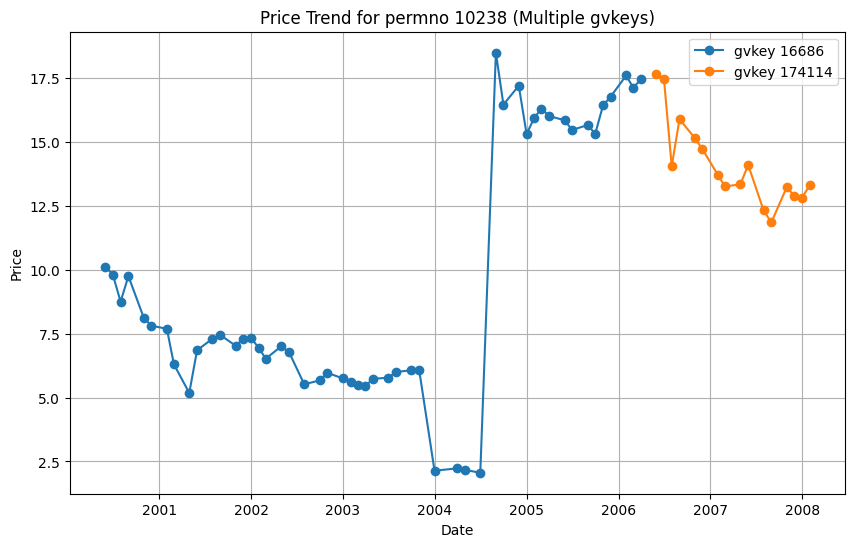

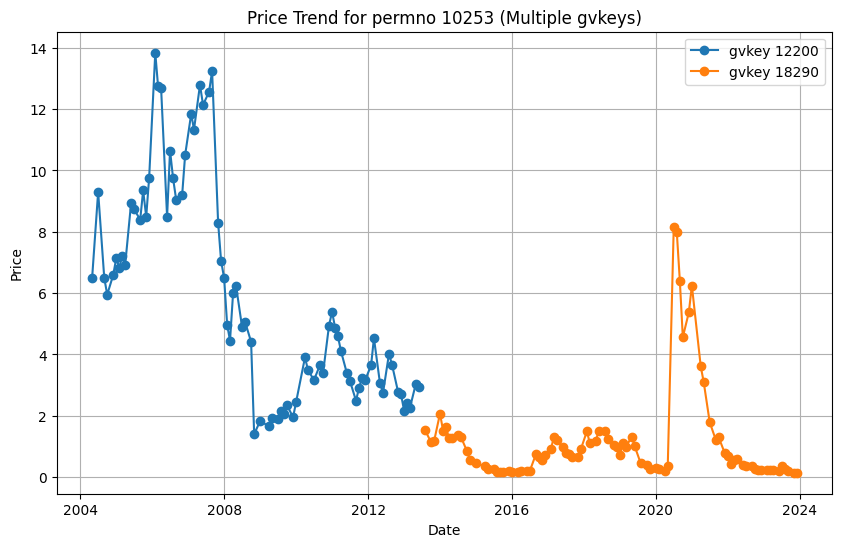

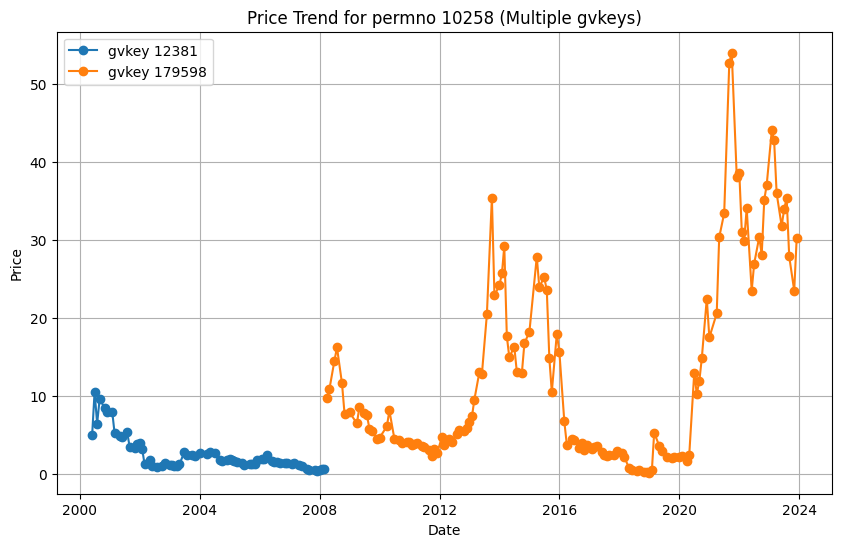

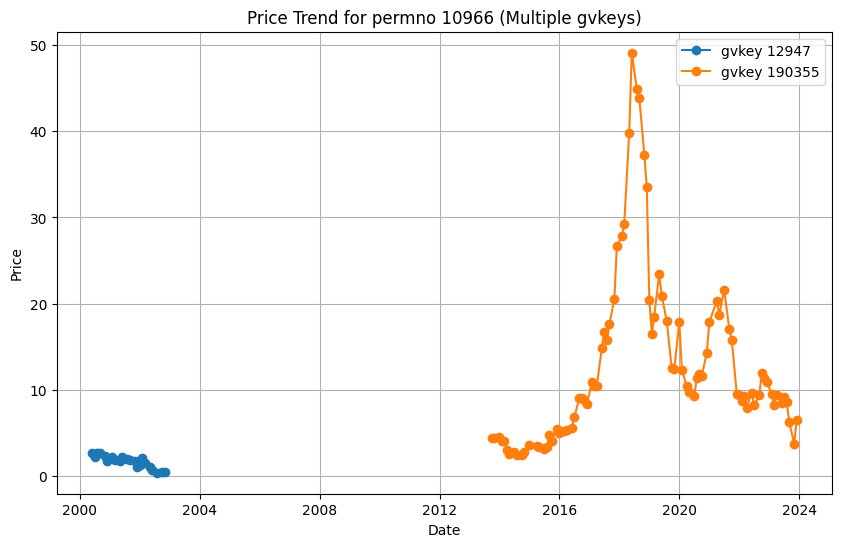

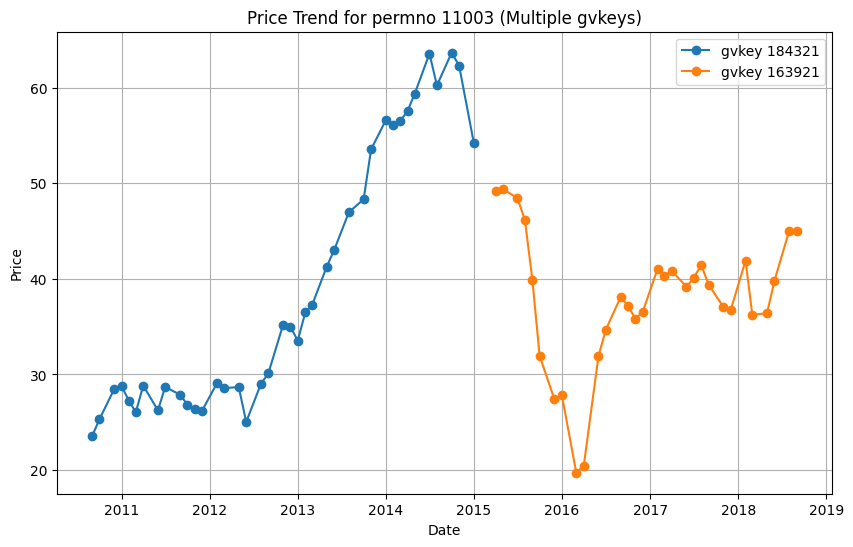

In [ ]:
# Persistent state for tracking which permnos have been plotted
if 'permno_index' not in globals():
    permno_index = 0  # Initialize the index if it doesn't exist

def plot_next_five_permnos():
    """
    Plot the next five permnos with multiple gvkeys.
    Run this function repeatedly to see the next set of plots.
    """
    global permno_index  # Keep track of the current index
    end_index = permno_index + 5  # Determine the range of permnos to plot

    for permno in multiple_gvkeys_permnos[permno_index:end_index]:
        permno_df = complete_df[complete_df['permno'] == permno]
        unique_gvkeys = permno_df['gvkey'].unique()

        # Plot price trends for the current permno
        plt.figure(figsize=(10, 6))
        for gvkey in unique_gvkeys:
            gvkey_df = permno_df[permno_df['gvkey'] == gvkey]
            plt.plot(gvkey_df['date'], gvkey_df['prc'], marker='o', linestyle='-', label=f'gvkey {gvkey}')

        plt.title(f'Price Trend for permno {permno} (Multiple gvkeys)')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.show()

    permno_index = end_index  # Update the index for the next call
    if permno_index >= len(multiple_gvkeys_permnos):
        print("No more permnos to display.")

# Run the function to plot the first set of permnos
plot_next_five_permnos()

##### Handling PERMNOs with multiple gvkeys

After inspection we found that 3% of PERMNOs (480 out of 16417) show multiple gvkeys after merging, this could be due to company restructurings or M&As. Our decision for the sake of processability is to check if these PERMNOs represent companies that were listed in the S&P 500 in the time horizon considered, and if they are not, we drop them. Hoewever, this will be listed as a Research Limitation and addressed in the Future Improvements section

In [ ]:
unclean_caee_df = pd.read_csv(folder_path+'complete_CAEE_df.csv')
unclean_caee_df

,permno,date,prc,vol,ret,shrout,retx,gvkey,atq,ceqq,...,seqq,dvpq,ltq,InflationRate,IR,mktrf,smb,hml,rf,umd
0,10001,2000-05-31,7.90625,221.0,-0.023166,2464.0,-0.023166,12994,NaN,NaN,...,NaN,NaN,NaN,0.001755,0.0579,-0.0442,-0.0605,0.0475,0.0050,-0.0898
1,10001,2000-06-30,8.00000,350.0,0.027668,2475.0,0.011858,12994,50.225,14.218,...,14.218,0.0,36.007,0.005841,0.0569,0.0464,0.1284,-0.0842,0.0040,0.1660
2,10001,2000-07-31,7.87500,560.0,-0.015625,2475.0,-0.015625,12994,50.225,14.218,...,14.218,0.0,36.007,0.002904,0.0596,-0.0251,-0.0307,0.0831,0.0048,-0.0005
3,10001,2000-08-31,8.25000,1882.0,0.047619,2475.0,0.047619,12994,50.225,14.218,...,14.218,0.0,36.007,0.000000,0.0609,0.0703,-0.0061,-0.0139,0.0050,0.0573
4,10001,2000-10-31,9.00000,577.0,0.028571,2496.0,0.028571,12994,50.553,13.961,...,13.961,0.0,36.592,0.001728,0.0611,-0.0276,-0.0388,0.0571,0.0056,-0.0448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219793,93436,2023-06-30,261.76999,34409322.0,0.283627,3174000.0,0.283627,184996,86833.000,48054.000,...,48054.000,0.0,37598.000,0.002103,0.0516,0.0647,0.0155,-0.0020,0.0040,-0.0235
1219794,93436,2023-07-31,267.42999,23934292.0,0.021622,3173994.0,0.021622,184996,86833.000,48054.000,...,48054.000,0.0,37598.000,0.002056,0.0525,0.0321,0.0205,0.0411,0.0045,-0.0405
1219795,93436,2023-08-31,258.07999,25029170.0,-0.034962,3173994.0,-0.034962,184996,86833.000,48054.000,...,48054.000,0.0,37598.000,0.005118,0.0530,-0.0239,-0.0320,-0.0108,0.0045,0.0377
1219796,93436,2023-10-31,200.84000,25905681.0,-0.197346,3178921.0,-0.197346,184996,90591.000,51130.000,...,51130.000,0.0,38409.000,0.000791,0.0534,-0.0318,-0.0388,0.0019,0.0047,0.0168


In [ ]:
names_df = pd.read_csv(folder_path+'crsp_msenames.csv')
names_df

,Unnamed: 0,permno,namedt,nameendt,ncusip,ticker,comnam,shrcd,exchcd
0,0,10000,1986-01-07,1986-12-03,68391610,OMFGA,OPTIMUM MANUFACTURING INC,10,3
1,1,10000,1986-12-04,1987-03-09,68391610,OMFGA,OPTIMUM MANUFACTURING INC,10,3
2,2,10000,1987-03-10,1987-06-11,68391610,OMFGA,OPTIMUM MANUFACTURING INC,10,3
3,3,10001,1986-01-09,1993-11-21,39040610,GFGC,GREAT FALLS GAS CO,11,3
4,4,10001,1993-11-22,2004-06-09,29274A10,EWST,ENERGY WEST INC,11,3
...,...,...,...,...,...,...,...,...,...
113851,113851,93434,2010-06-14,2023-12-29,78513510,SANW,S & W SEED CO,11,3
113852,113852,93435,2010-06-14,2012-05-18,82936G20,SCEI,SINO CLEAN ENERGY INC,11,3
113853,113853,93436,2010-06-29,2017-02-01,88160R10,TSLA,TESLA MOTORS INC,11,3
113854,113854,93436,2017-02-02,2023-04-02,88160R10,TSLA,TESLA INC,11,3


##### Inspecting the Importance of Mismatched PERMNOs

In [ ]:
# Identify permnos linked to multiple gvkeys
mismatched_permnos = (
    unclean_caee_df.groupby('permno')['gvkey']
    .nunique()
    .reset_index()
    .rename(columns={'gvkey': 'unique_gvkeys'})
)

# Filter permnos with more than 1 gvkey
mismatched_permnos = mismatched_permnos[mismatched_permnos['unique_gvkeys'] > 1]

# List of mismatched permnos
mismatched_permnos_list = mismatched_permnos['permno'].unique()

# Filter CRSP names for the mismatched permnos
multiple_permnos_tickers = names_df[names_df['permno'].isin(mismatched_permnos_list)][['permno', 'ticker', 'comnam']]
print(multiple_permnos_tickers)

        permno ticker                           comnam
871      10238   BVFS       BAY VIEW FED S & L ASSN CA
872      10238   BVFS       BAY VIEW FED S & L ASSN CA
873      10238   BVFS            BAY VIEW CAPITAL CORP
874      10238   BVCC            BAY VIEW CAPITAL CORP
875      10238    BVC            BAY VIEW CAPITAL CORP
...        ...    ...                              ...
113630   93350   LLIT                LIANLUO SMART LTD
113631   93350   NEGG              NEWEGG COMMERCE INC
113760   93396   KONE  KINGTONE WIRELESSINFO SLTN HLDG
113761   93396   KONE  KINGTONE WIRELESSINFO SLTN HLDG
113762   93396   LKCO          LUOKUNG TECHNOLOGY CORP

[2632 rows x 3 columns]


In [ ]:
multiple_permnos_tickers.to_csv('multiple_permnos_tickers.csv', index=False)

In [ ]:
mismatched_names = pd.read_csv('multiple_permnos_tickers.csv')
mismatched_names_df = pd.DataFrame(mismatched_names)

mismatched_names_df

,permno,ticker,comnam
0,10238,BVFS,BAY VIEW FED S & L ASSN CA
1,10238,BVFS,BAY VIEW FED S & L ASSN CA
2,10238,BVFS,BAY VIEW CAPITAL CORP
3,10238,BVCC,BAY VIEW CAPITAL CORP
4,10238,BVC,BAY VIEW CAPITAL CORP
...,...,...,...
2627,93350,LLIT,LIANLUO SMART LTD
2628,93350,NEGG,NEWEGG COMMERCE INC
2629,93396,KONE,KINGTONE WIRELESSINFO SLTN HLDG
2630,93396,KONE,KINGTONE WIRELESSINFO SLTN HLDG


##### Dropping the Mismatched PERMNOs

In [ ]:
mismatched_permnos['permno']

,permno
66,10238
70,10253
73,10258
223,10966
232,11003
...,...
16062,92716
16162,92949
16248,93106
16361,93350


In [ ]:
# Drop rows with mismatched permnos
filtered_df = unclean_caee_df[~unclean_caee_df['permno'].isin(mismatched_permnos['permno'])]

# Verify the result
print(f"Original DataFrame size: {unclean_caee_df.shape}")
print(f"Filtered DataFrame size: {filtered_df.shape}")
print(f"Number of rows dropped: {unclean_caee_df.shape[0] - filtered_df.shape[0]}")

Original DataFrame size: (1219798, 23)
Filtered DataFrame size: (1179501, 23)
Number of rows dropped: 40297


In [ ]:
# Check for mismatched permnos in caee_df
mismatched_present = filtered_df['permno'].isin(mismatched_permnos['permno'])

# Count how many mismatched permnos are present
num_present = mismatched_present.sum()

# Check which mismatched permnos are found in caee_df
found_permnos = filtered_df.loc[mismatched_present, 'permno'].unique()

# Output the results
print(f"Total mismatched permnos: {len(mismatched_permnos)}")
print(f"Number of mismatched permnos found in filtered_df: {num_present}")
print(f"Mismatched permnos present in filtered_df: {found_permnos}")

Total mismatched permnos: 480
Number of mismatched permnos found in filtered_df: 0
Mismatched permnos present in filtered_df: []


In [ ]:
caee_df = filtered_df

In [ ]:
caee_df.to_csv('caee_df.csv', index=False)
print("Processed Complete Data saved to 'caee_df.csv'")

Processed Complete Data saved to 'caee_df.csv'


## Section 3 - Constructing 12 Factor Portfolios

Methodology: We construct each portfolio by ranking all the stocks in our CAEE dataframe on specific metrics relative to the underlying portfolio, each month.

Each calculated rank will serve for the month after, meaning that when allocating weights to the final portfolio based on the factors top performers we have to take into account the ranks of the month before to allocate

e.g. 120 total stocks were selected (10 from each portfolio) as highest ranked in their respective portfolio for the month of December 2021, therefore if we want to allocate weights for January 2022, we should take into account the values for Decemebr 2021 and so on

For now, we just construct the portfolios and assign ranks for each month

### Calculating Factors for each Portfolio

In [4]:
caee_df = pd.read_csv(folder_path + 'caee_df.csv')

In [5]:
caee_df.columns

Index(['permno', 'date', 'prc', 'vol', 'ret', 'shrout', 'retx', 'gvkey', 'atq',
       'ceqq', 'ibq', 'saleq', 'capxy', 'seqq', 'dvpq', 'ltq', 'InflationRate',
       'IR', 'mktrf', 'smb', 'hml', 'rf', 'umd'],
      dtype='object')

#### 1. Value Portfolio

Metrics: Book-to-Market Ratio (B/M), Enterprise Multiple (EV/EBITDA)

In [125]:
# Visualize the columns of interest
columns_to_visualize = ['permno', 'date', 'prc', 'shrout', 'ceqq', 'ibq', 'capxy']

# Display the first few rows of the selected columns
print(caee_df[columns_to_visualize].head())

# Display a random sample of rows for better understanding
print(caee_df[columns_to_visualize].sample(10))

   permno        date      prc  shrout    ceqq    ibq  capxy
0   10001  2000-05-31  7.90625  2464.0     NaN    NaN    NaN
1   10001  2000-06-30  8.00000  2475.0  14.218  1.441    NaN
2   10001  2000-07-31  7.87500  2475.0  14.218  1.441    NaN
3   10001  2000-08-31  8.25000  2475.0  14.218  1.441    NaN
4   10001  2000-10-31  9.00000  2496.0  13.961 -0.154    NaN
         permno        date    prc     shrout       ceqq       ibq     capxy
1008921   89978  2004-03-31   7.05    13904.0      2.723     0.331     1.167
204246    18428  2021-03-31  63.94   745225.0  12435.000  1236.000  1257.000
1089294   91187  2010-11-30   3.10     4680.0     39.007     1.255     0.179
990927    89761  2005-11-30   3.48     6309.0     16.886     0.030     0.220
466512    76259  2003-12-31  13.09    23470.0     49.475     0.893     2.016
599323    80102  2011-11-30  35.74    21703.0    -95.969    -0.890     0.000
1157103   92802  2020-11-30   5.80    69299.0  13834.942    72.567    87.702
1040825   90441  2

In [126]:
# Ensure proper data types and sort the DataFrame
caee_df['prc'] = caee_df['prc'].astype(float)
caee_df['shrout'] = caee_df['shrout'].astype(float)
caee_df['ceqq'] = caee_df['ceqq'].astype(float)
caee_df['ibq'] = caee_df['ibq'].astype(float)
caee_df['capxy'] = caee_df['capxy'].astype(float)

# Calculate Market Value (mv): Absolute Price * Shares Outstanding
caee_df['mv'] = caee_df['prc'].abs() * caee_df['shrout']

caee_df

,permno,date,prc,vol,ret,shrout,retx,gvkey,atq,ceqq,...,dvpq,ltq,InflationRate,IR,mktrf,smb,hml,rf,umd,mv
0,10001,2000-05-31,7.90625,221.0,-0.023166,2464.0,-0.023166,12994,NaN,NaN,...,NaN,NaN,0.001755,0.0579,-0.0442,-0.0605,0.0475,0.0050,-0.0898,1.948100e+04
1,10001,2000-06-30,8.00000,350.0,0.027668,2475.0,0.011858,12994,50.225,14.218,...,0.0,36.007,0.005841,0.0569,0.0464,0.1284,-0.0842,0.0040,0.1660,1.980000e+04
2,10001,2000-07-31,7.87500,560.0,-0.015625,2475.0,-0.015625,12994,50.225,14.218,...,0.0,36.007,0.002904,0.0596,-0.0251,-0.0307,0.0831,0.0048,-0.0005,1.949062e+04
3,10001,2000-08-31,8.25000,1882.0,0.047619,2475.0,0.047619,12994,50.225,14.218,...,0.0,36.007,0.000000,0.0609,0.0703,-0.0061,-0.0139,0.0050,0.0573,2.041875e+04
4,10001,2000-10-31,9.00000,577.0,0.028571,2496.0,0.028571,12994,50.553,13.961,...,0.0,36.592,0.001728,0.0611,-0.0276,-0.0388,0.0571,0.0056,-0.0448,2.246400e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179496,93436,2023-06-30,261.76999,34409322.0,0.283627,3174000.0,0.283627,184996,86833.000,48054.000,...,0.0,37598.000,0.002103,0.0516,0.0647,0.0155,-0.0020,0.0040,-0.0235,8.308579e+08
1179497,93436,2023-07-31,267.42999,23934292.0,0.021622,3173994.0,0.021622,184996,86833.000,48054.000,...,0.0,37598.000,0.002056,0.0525,0.0321,0.0205,0.0411,0.0045,-0.0405,8.488212e+08
1179498,93436,2023-08-31,258.07999,25029170.0,-0.034962,3173994.0,-0.034962,184996,86833.000,48054.000,...,0.0,37598.000,0.005118,0.0530,-0.0239,-0.0320,-0.0108,0.0045,0.0377,8.191443e+08
1179499,93436,2023-10-31,200.84000,25905681.0,-0.197346,3178921.0,-0.197346,184996,90591.000,51130.000,...,0.0,38409.000,0.000791,0.0534,-0.0318,-0.0388,0.0019,0.0047,0.0168,6.384545e+08


In [127]:
# Compute Book-to-Market Ratio (B/M)
# B/M = Book Value of Equity (ceqq) / Market Value (mv)
caee_df['book_to_market'] = caee_df['ceqq'] / caee_df['mv']
caee_df['book_to_market'] = caee_df['book_to_market'].fillna(0)  # Fill NaN values with 0

# Compute EBITDA (proxy: Earnings Before Interest, Taxes, Depreciation, and Amortization)
# EBITDA is approximated as Operating Income Before Depreciation (ibq) + Capital Expenditures (capxy)
caee_df['ebitda'] = caee_df['ibq'] + caee_df['capxy']
caee_df['ebitda'] = caee_df['ebitda'].fillna(0)  # Fill NaN values with 0

caee_df

,permno,date,prc,vol,ret,shrout,retx,gvkey,atq,ceqq,...,InflationRate,IR,mktrf,smb,hml,rf,umd,mv,book_to_market,ebitda
0,10001,2000-05-31,7.90625,221.0,-0.023166,2464.0,-0.023166,12994,NaN,NaN,...,0.001755,0.0579,-0.0442,-0.0605,0.0475,0.0050,-0.0898,1.948100e+04,0.000000,0.0
1,10001,2000-06-30,8.00000,350.0,0.027668,2475.0,0.011858,12994,50.225,14.218,...,0.005841,0.0569,0.0464,0.1284,-0.0842,0.0040,0.1660,1.980000e+04,0.000718,0.0
2,10001,2000-07-31,7.87500,560.0,-0.015625,2475.0,-0.015625,12994,50.225,14.218,...,0.002904,0.0596,-0.0251,-0.0307,0.0831,0.0048,-0.0005,1.949062e+04,0.000729,0.0
3,10001,2000-08-31,8.25000,1882.0,0.047619,2475.0,0.047619,12994,50.225,14.218,...,0.000000,0.0609,0.0703,-0.0061,-0.0139,0.0050,0.0573,2.041875e+04,0.000696,0.0
4,10001,2000-10-31,9.00000,577.0,0.028571,2496.0,0.028571,12994,50.553,13.961,...,0.001728,0.0611,-0.0276,-0.0388,0.0571,0.0056,-0.0448,2.246400e+04,0.000621,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179496,93436,2023-06-30,261.76999,34409322.0,0.283627,3174000.0,0.283627,184996,86833.000,48054.000,...,0.002103,0.0516,0.0647,0.0155,-0.0020,0.0040,-0.0235,8.308579e+08,0.000058,4586.0
1179497,93436,2023-07-31,267.42999,23934292.0,0.021622,3173994.0,0.021622,184996,86833.000,48054.000,...,0.002056,0.0525,0.0321,0.0205,0.0411,0.0045,-0.0405,8.488212e+08,0.000057,4586.0
1179498,93436,2023-08-31,258.07999,25029170.0,-0.034962,3173994.0,-0.034962,184996,86833.000,48054.000,...,0.005118,0.0530,-0.0239,-0.0320,-0.0108,0.0045,0.0377,8.191443e+08,0.000059,4586.0
1179499,93436,2023-10-31,200.84000,25905681.0,-0.197346,3178921.0,-0.197346,184996,90591.000,51130.000,...,0.000791,0.0534,-0.0318,-0.0388,0.0019,0.0047,0.0168,6.384545e+08,0.000080,6836.0


In [128]:
# Keep necessary columns for next steps
value_df = caee_df[['permno', 'date', 'book_to_market', 'ebitda']].copy()

# Save the results to a file if needed
# value_df.to_csv('value_factors.csv', index=False)

In [129]:
value_df

,permno,date,book_to_market,ebitda
0,10001,2000-05-31,0.000000,0.0
1,10001,2000-06-30,0.000718,0.0
2,10001,2000-07-31,0.000729,0.0
3,10001,2000-08-31,0.000696,0.0
4,10001,2000-10-31,0.000621,0.0
...,...,...,...,...
1179496,93436,2023-06-30,0.000058,4586.0
1179497,93436,2023-07-31,0.000057,4586.0
1179498,93436,2023-08-31,0.000059,4586.0
1179499,93436,2023-10-31,0.000080,6836.0


In [130]:
# Get unique dates (months) from value_df
unique_dates = value_df['date'].unique()

# Initialize an empty dictionary to store monthly data
monthly_data_dict = {}

# Loop through each unique date (month)
for month in unique_dates:
    # Filter value_df for the current month
    monthly_data = value_df[value_df['date'] == month][['permno', 'book_to_market', 'ebitda']]

    # Store the current month's data in the dictionary
    monthly_data_dict[month] = monthly_data

# Display the first entry in the dictionary for inspection
for month, data in list(monthly_data_dict.items())[:1]:
    print(f"Month: {month}")
    print(data.head())

Month: 2000-05-31
     permno  book_to_market  ebitda
0     10001        0.000000    0.00
148   10002        0.000000    0.00
258   10009        0.000000    0.00
264   10012        0.000086    2.37
308   10016        0.000000    0.00


In [131]:
# Initialize separate dictionaries for book_to_market and ebitda
bm_dict = {}
ebitda_dict = {}

# Loop through each month in the value_df
for month, group in value_df.groupby('date'):
    # Copy the group for book_to_market ranking
    bm_group = group.copy()
    bm_group['bm_rank'] = bm_group['book_to_market'].rank(
        method='min', ascending=False).astype(int)
    bm_group = bm_group.sort_values(by='bm_rank')
    bm_dict[month] = bm_group[['permno', 'book_to_market', 'bm_rank']]

    # Copy the group for ebitda ranking
    ebitda_group = group.copy()
    ebitda_group['ebitda_rank'] = ebitda_group['ebitda'].rank(
        method='min', ascending=False).astype(int)
    ebitda_group = ebitda_group.sort_values(by='ebitda_rank')
    ebitda_dict[month] = ebitda_group[['permno', 'ebitda', 'ebitda_rank']]

# Inspect the first few months for each dictionary
print("BM Dictionary:")
for month, df in list(bm_dict.items())[:3]:  # Show first 3 months
    print(f"Month: {month}")
    print(df.head())

print("\nEBITDA Dictionary:")
for month, df in list(ebitda_dict.items())[:3]:  # Show first 3 months
    print(f"Month: {month}")
    print(df.head())


BM Dictionary:
Month: 2000-03-31
        permno  book_to_market  bm_rank
45103    12113             0.0        1
368117   58975             0.0        1
438614   75386             0.0        1
487375   76931             0.0        1
542655   78713             0.0        1
Month: 2000-05-31
        permno  book_to_market  bm_rank
278710   28303        8.547837        1
847163   87068        0.081778        2
324913   46085        0.057233        3
697063   83591        0.019850        4
438615   75386        0.015821        5
Month: 2000-06-30
        permno  book_to_market  bm_rank
278711   28303        7.479357        1
687393   83335        3.286432        2
654038   81782        3.246138        3
782117   85777        1.114842        4
687416   83336        1.097500        5

EBITDA Dictionary:
Month: 2000-03-31
        permno  ebitda  ebitda_rank
45103    12113     0.0            1
368117   58975     0.0            1
438614   75386     0.0            1
487375   76931     0.0       

In [133]:
# Initialize dictionaries to store the top 1% for bm and ebitda
bm_top_1_dict = {}
ebitda_top_1_dict = {}

# Percentage for top selection
top_percentage = 0.01

# Process the BM Dictionary
for month, df in bm_dict.items():
    top_n = max(1, int(len(df) * top_percentage))  # Ensure at least 1 row is selected
    bm_top_1_dict[month] = df.head(top_n)

# Process the EBITDA Dictionary
for month, df in ebitda_dict.items():
    top_n = max(1, int(len(df) * top_percentage))  # Ensure at least 1 row is selected
    ebitda_top_1_dict[month] = df.head(top_n)

# Preview the results for BM
print("BM Top 1% Dictionary:")
for month, df in list(bm_top_1_dict.items())[:3]:  # Show first 3 months
    print(f"Month: {month}")
    print(df)

# Preview the results for EBITDA
print("\nEBITDA Top 1% Dictionary:")
for month, df in list(ebitda_top_1_dict.items())[:3]:  # Show first 3 months
    print(f"Month: {month}")
    print(df)

BM Top 1% Dictionary:
Month: 2000-03-31
       permno  book_to_market  bm_rank
45103   12113             0.0        1
Month: 2000-05-31
        permno  book_to_market  bm_rank
278710   28303        8.547837        1
847163   87068        0.081778        2
324913   46085        0.057233        3
697063   83591        0.019850        4
438615   75386        0.015821        5
...        ...             ...      ...
332719   48143        0.002416       77
762098   85402        0.002415       78
244401   21785        0.002399       79
629065   80971        0.002370       80
325195   46237        0.002338       81

[81 rows x 3 columns]
Month: 2000-06-30
        permno  book_to_market  bm_rank
278711   28303        7.479357        1
687393   83335        3.286432        2
654038   81782        3.246138        3
782117   85777        1.114842        4
687416   83336        1.097500        5
...        ...             ...      ...
390629   64231        0.017513       77
717650   84083        0

In [134]:
# Function to save a dictionary to a CSV
def save_dict_to_csv(data_dict, file_name, key_column_name='month'):
    # Combine all DataFrames into one
    combined_df = pd.concat(
        [df.assign(**{key_column_name: key}) for key, df in data_dict.items()],
        ignore_index=True
    )
    # Save to CSV
    combined_df.to_csv(file_name, index=False)

# Save BM Top 1% Dictionary to CSV
save_dict_to_csv(bm_top_1_dict, "bm_top_1_percent.csv")

# Save EBITDA Top 1% Dictionary to CSV
save_dict_to_csv(ebitda_top_1_dict, "ebitda_top_1_percent.csv")

print("BM and EBITDA Top 1% dictionaries have been saved to CSV files!")

BM and EBITDA Top 1% dictionaries have been saved to CSV files!


#### 2. Momentum Portfolio

Metrics: 6-12 month Returns, 12-24 month Returns

In [135]:
# Visualize the columns of interest for momentum portfolio
columns_to_visualize = ['permno', 'date', 'ret']  # Use 'ret' for monthly returns

# Display the first few rows of the selected columns
print(caee_df[columns_to_visualize].head())

# Display a random sample of rows for better understanding
print(caee_df[columns_to_visualize].sample(10))

   permno        date       ret
0   10001  2000-05-31 -0.023166
1   10001  2000-06-30  0.027668
2   10001  2000-07-31 -0.015625
3   10001  2000-08-31  0.047619
4   10001  2000-10-31  0.028571
         permno        date       ret
446206    75600  2002-04-30  0.032071
383656    62341  2021-09-30  0.137964
944799    89167  2019-04-30  0.002845
1133016   92195  2009-09-30  0.025872
677050    82795  2000-08-31 -0.033784
458102    76052  2010-03-31  0.046859
2461      10104  2018-11-30 -0.001638
599466    80112  2003-10-31  0.116471
192586    17802  2019-10-31 -0.030162
556104    79057  2004-03-31 -0.046931


In [137]:
# Ensure data is sorted by permno and date
caee_df = caee_df.sort_values(by=['permno', 'date']).reset_index(drop=True)

# Function to calculate rolling returns
def calculate_cumulative_returns(series, window):
    return (1 + series).rolling(window=window, min_periods=window).apply(lambda x: x.prod() - 1, raw=True)

# Compute 6-12 Month Returns
caee_df['ret_6_12'] = (
    caee_df.groupby('permno')['ret']
    .apply(lambda x: calculate_cumulative_returns(x.shift(6), 6))
).reset_index(level=0, drop=True)

# Compute 12-24 Month Returns
caee_df['ret_12_24'] = (
    caee_df.groupby('permno')['ret']
    .apply(lambda x: calculate_cumulative_returns(x.shift(12), 12))
).reset_index(level=0, drop=True)

# Replace NaN values with 0 to avoid missing data
caee_df['ret_6_12'] = caee_df['ret_6_12'].fillna(0)
caee_df['ret_12_24'] = caee_df['ret_12_24'].fillna(0)

# Preview the resulting DataFrame
print(caee_df[['permno', 'date', 'ret_6_12', 'ret_12_24']].head())

   permno        date  ret_6_12  ret_12_24
0   10001  2000-05-31       0.0        0.0
1   10001  2000-06-30       0.0        0.0
2   10001  2000-07-31       0.0        0.0
3   10001  2000-08-31       0.0        0.0
4   10001  2000-10-31       0.0        0.0


In [138]:
# Keep only the relevant columns for the momentum factors
momentum_df = caee_df[['permno', 'date', 'ret_6_12', 'ret_12_24']].copy()

# Preview the resulting DataFrame
print(momentum_df.head())

   permno        date  ret_6_12  ret_12_24
0   10001  2000-05-31       0.0        0.0
1   10001  2000-06-30       0.0        0.0
2   10001  2000-07-31       0.0        0.0
3   10001  2000-08-31       0.0        0.0
4   10001  2000-10-31       0.0        0.0


In [139]:
# Get unique dates (months) from momentum_df
unique_dates = momentum_df['date'].unique()

# Initialize an empty dictionary to store monthly data
monthly_data_dict = {}

# Loop through each unique date (month) and filter data for that month
for month in unique_dates:
    monthly_data = momentum_df[momentum_df['date'] == month][['permno', 'ret_6_12', 'ret_12_24']]
    monthly_data_dict[month] = monthly_data

# Preview the first entry in the dictionary
for month, data in list(monthly_data_dict.items())[:1]:
    print(f"Month: {month}")
    print(data.head())

Month: 2000-05-31
     permno  ret_6_12  ret_12_24
0     10001       0.0        0.0
148   10002       0.0        0.0
258   10009       0.0        0.0
264   10012       0.0        0.0
308   10016       0.0        0.0


In [140]:
# Initialize separate dictionaries for ret_6_12 and ret_12_24
ret_6_12_dict = {}
ret_12_24_dict = {}

# Loop through each month in the momentum_df
for month, group in momentum_df.groupby('date'):
    # Rank permnos by ret_6_12
    ret_6_12_group = group.copy()
    ret_6_12_group['ret_6_12_rank'] = ret_6_12_group['ret_6_12'].rank(ascending=False, method='min').astype(int)
    ret_6_12_group = ret_6_12_group.sort_values(by='ret_6_12_rank')
    ret_6_12_dict[month] = ret_6_12_group[['permno', 'ret_6_12', 'ret_6_12_rank']]

    # Rank permnos by ret_12_24
    ret_12_24_group = group.copy()
    ret_12_24_group['ret_12_24_rank'] = ret_12_24_group['ret_12_24'].rank(ascending=False, method='min').astype(int)
    ret_12_24_group = ret_12_24_group.sort_values(by='ret_12_24_rank')
    ret_12_24_dict[month] = ret_12_24_group[['permno', 'ret_12_24', 'ret_12_24_rank']]

# Inspect the dictionaries
print("6-12 Month Returns Dictionary:")
for month, df in list(ret_6_12_dict.items())[:3]:
    print(f"Month: {month}")
    print(df.head())

print("\n12-24 Month Returns Dictionary:")
for month, df in list(ret_12_24_dict.items())[:3]:
    print(f"Month: {month}")
    print(df.head())


6-12 Month Returns Dictionary:
Month: 2000-03-31
        permno  ret_6_12  ret_6_12_rank
45103    12113       0.0              1
368117   58975       0.0              1
438614   75386       0.0              1
487375   76931       0.0              1
542655   78713       0.0              1
Month: 2000-05-31
        permno  ret_6_12  ret_6_12_rank
0        10001       0.0              1
703976   83741       0.0              1
703901   83740       0.0              1
703895   83739       0.0              1
703694   83738       0.0              1
Month: 2000-06-30
        permno  ret_6_12  ret_6_12_rank
1        10001       0.0              1
706947   83833       0.0              1
706833   83832       0.0              1
706663   83831       0.0              1
706649   83830       0.0              1

12-24 Month Returns Dictionary:
Month: 2000-03-31
        permno  ret_12_24  ret_12_24_rank
45103    12113        0.0               1
368117   58975        0.0               1
438614   75386    

In [141]:
# Initialize dictionaries to store the top 1% for 6-12 and 12-24 month returns
ret_6_12_top_1_dict = {}
ret_12_24_top_1_dict = {}

# Percentage for top selection
top_percentage = 0.01

# Process the 6-12 Month Returns Dictionary
for month, df in ret_6_12_dict.items():
    top_n = max(1, int(len(df) * top_percentage))  # Ensure at least 1 row is selected
    ret_6_12_top_1_dict[month] = df.head(top_n)

# Process the 12-24 Month Returns Dictionary
for month, df in ret_12_24_dict.items():
    top_n = max(1, int(len(df) * top_percentage))  # Ensure at least 1 row is selected
    ret_12_24_top_1_dict[month] = df.head(top_n)

# Preview the results
print("6-12 Month Returns Top 1% Dictionary:")
for month, df in list(ret_6_12_top_1_dict.items())[:3]:
    print(f"Month: {month}")
    print(df)

print("\n12-24 Month Returns Top 1% Dictionary:")
for month, df in list(ret_12_24_top_1_dict.items())[:3]:
    print(f"Month: {month}")
    print(df)


6-12 Month Returns Top 1% Dictionary:
Month: 2000-03-31
       permno  ret_6_12  ret_6_12_rank
45103   12113       0.0              1
Month: 2000-05-31
        permno  ret_6_12  ret_6_12_rank
0        10001       0.0              1
703976   83741       0.0              1
703901   83740       0.0              1
703895   83739       0.0              1
703694   83738       0.0              1
...        ...       ...            ...
698308   83618       0.0              1
699331   83637       0.0              1
698173   83616       0.0              1
698110   83613       0.0              1
698049   83610       0.0              1

[81 rows x 3 columns]
Month: 2000-06-30
        permno  ret_6_12  ret_6_12_rank
1        10001       0.0              1
706947   83833       0.0              1
706833   83832       0.0              1
706663   83831       0.0              1
706649   83830       0.0              1
...        ...       ...            ...
702452   83701       0.0              1
702344 

In [142]:
# Define a function to save a dictionary to a CSV file
def save_dict_to_csv(data_dict, file_name, key_column_name='month'):
    # Combine all DataFrames into one
    combined_df = pd.concat(
        [df.assign(**{key_column_name: key}) for key, df in data_dict.items()],
        ignore_index=True
    )
    # Save to CSV
    combined_df.to_csv(file_name, index=False)

# Save the Top 1% Dictionaries
save_dict_to_csv(ret_6_12_top_1_dict, "ret_6_12_top_1_percent.csv")
save_dict_to_csv(ret_12_24_top_1_dict, "ret_12_24_top_1_percent.csv")

print("Momentum Top 1% dictionaries have been saved to CSV files!")


Momentum Top 1% dictionaries have been saved to CSV files!


#### 3. Size Portfolio:

Metrics: Market Cap

In [143]:
# Calculate Market Cap if not already done
if 'mv' not in caee_df.columns:
    caee_df['mv'] = caee_df['prc'].abs() * caee_df['shrout']  # Market Value = |Price| * Shares Outstanding

In [145]:
# Initialize a dictionary for the Size Portfolio
size_dict = {}

# Loop through each month and rank by Market Cap
for month, group in caee_df.groupby('date'):
    size_group = group.copy()

    # Handle NaN or infinite values in 'mv'
    size_group['mv'] = size_group['mv'].replace([np.inf, -np.inf], np.nan).fillna(0)

    # Rank permnos by Market Cap
    size_group['size_rank'] = size_group['mv'].rank(ascending=False, method='min').astype(int)

    # Sort by rank for clarity
    size_group = size_group.sort_values(by='size_rank')

    # Store the ranked DataFrame in the dictionary
    size_dict[month] = size_group[['permno', 'mv', 'size_rank']]

# Preview the first few months
for month, df in list(size_dict.items())[:3]:
    print(f"Month: {month}")
    print(df.head())

Month: 2000-03-31
        permno            mv  size_rank
713983   84005  1.792928e+07          1
438614   75386  8.458918e+05          2
838850   86925  6.589399e+05          3
368117   58975  4.266938e+05          4
673712   82704  3.225531e+05          5
Month: 2000-05-31
        permno            mv  size_rank
42453    12060  5.212599e+08          1
370316   59328  4.175784e+08          2
458329   76076  3.999206e+08          3
2505     10107  3.292292e+08          4
37853    11850  2.900214e+08          5
Month: 2000-06-30
        permno            mv  size_rank
42454    12060  5.243516e+08          1
458330   76076  4.512107e+08          2
370317   59328  4.477194e+08          3
2506     10107  4.209924e+08          4
246505   21936  3.021372e+08          5


In [146]:
# Initialize a dictionary to store the top 1% by Market Cap
size_top_1_dict = {}

# Percentage for top selection
top_percentage = 0.01

# Process the Size Portfolio
for month, df in size_dict.items():
    top_n = max(1, int(len(df) * top_percentage))  # Ensure at least 1 row is selected
    size_top_1_dict[month] = df.head(top_n)

# Preview the top 1% results
for month, df in list(size_top_1_dict.items())[:3]:
    print(f"Month: {month}")
    print(df.head())

Month: 2000-03-31
        permno          mv  size_rank
713983   84005  17929280.0          1
Month: 2000-05-31
        permno            mv  size_rank
42453    12060  5.212599e+08          1
370316   59328  4.175784e+08          2
458329   76076  3.999206e+08          3
2505     10107  3.292292e+08          4
37853    11850  2.900214e+08          5
Month: 2000-06-30
        permno            mv  size_rank
42454    12060  5.243516e+08          1
458330   76076  4.512107e+08          2
370317   59328  4.477194e+08          3
2506     10107  4.209924e+08          4
246505   21936  3.021372e+08          5


In [147]:
# Function to save a dictionary to a CSV file
def save_dict_to_csv(data_dict, file_name, key_column_name='month'):
    combined_df = pd.concat(
        [df.assign(**{key_column_name: key}) for key, df in data_dict.items()],
        ignore_index=True
    )
    combined_df.to_csv(file_name, index=False)

# Save Size Top 1% Portfolio to CSV
save_dict_to_csv(size_top_1_dict, "size_top_1_percent.csv", key_column_name="month")

print("Size Top 1% Portfolio has been saved to 'size_top_1_percent.csv'!")

Size Top 1% Portfolio has been saved to 'size_top_1_percent.csv'!


#### 4. Quality Portfolio

Metrics: Quality Minus Junk (QMJ), Earnings-to-Price Ratio

In [148]:
# Keep the necessary columns for Quality Metrics
quality_df = caee_df[['permno', 'date', 'ceqq', 'ibq', 'prc', 'shrout']].copy()

# Ensure proper data types
quality_df['ceqq'] = quality_df['ceqq'].astype(float)
quality_df['ibq'] = quality_df['ibq'].astype(float)
quality_df['prc'] = quality_df['prc'].abs()  # Use absolute values for prices
quality_df['shrout'] = quality_df['shrout'].astype(float)

# Calculate Market Value (mv)
quality_df['mv'] = quality_df['prc'] * quality_df['shrout']

# Calculate Quality Minus Junk (QMJ)
# QMJ = Shareholder's Equity (ceqq) / Market Value (mv)
quality_df['qmj'] = quality_df['ceqq'] / quality_df['mv']
quality_df['qmj'] = quality_df['qmj'].fillna(0)  # Fill NaN with 0

# Calculate Earnings-to-Price Ratio (EP)
# EP = Earnings (ibq) / Price (prc)
quality_df['ep'] = quality_df['ibq'] / quality_df['prc']
quality_df['ep'] = quality_df['ep'].fillna(0)  # Fill NaN with 0

# Inspect the prepared DataFrame
print(quality_df.head())

   permno        date    ceqq    ibq      prc  shrout         mv       qmj  \
0   10001  2000-05-31     NaN    NaN  7.90625  2464.0  19481.000  0.000000   
1   10001  2000-06-30  14.218  1.441  8.00000  2475.0  19800.000  0.000718   
2   10001  2000-07-31  14.218  1.441  7.87500  2475.0  19490.625  0.000729   
3   10001  2000-08-31  14.218  1.441  8.25000  2475.0  20418.750  0.000696   
4   10001  2000-10-31  13.961 -0.154  9.00000  2496.0  22464.000  0.000621   

         ep  
0  0.000000  
1  0.180125  
2  0.182984  
3  0.174667  
4 -0.017111  


In [149]:
# Initialize separate dictionaries for QMJ and EP
qmj_dict = {}
ep_dict = {}

# Loop through each month in the data
for month, group in quality_df.groupby('date'):
    # Rank by QMJ
    qmj_group = group.copy()
    qmj_group['qmj_rank'] = qmj_group['qmj'].rank(ascending=False, method='min').astype(int)
    qmj_group = qmj_group.sort_values(by='qmj_rank')
    qmj_dict[month] = qmj_group[['permno', 'qmj', 'qmj_rank']]

    # Rank by EP
    ep_group = group.copy()
    ep_group['ep_rank'] = ep_group['ep'].rank(ascending=False, method='min').astype(int)
    ep_group = ep_group.sort_values(by='ep_rank')
    ep_dict[month] = ep_group[['permno', 'ep', 'ep_rank']]

# Preview QMJ and EP dictionaries
print("QMJ Dictionary:")
for month, df in list(qmj_dict.items())[:3]:  # Show first 3 months
    print(f"Month: {month}")
    print(df.head())

print("\nEP Dictionary:")
for month, df in list(ep_dict.items())[:3]:  # Show first 3 months
    print(f"Month: {month}")
    print(df.head())

QMJ Dictionary:
Month: 2000-03-31
        permno  qmj  qmj_rank
45103    12113  0.0         1
368117   58975  0.0         1
438614   75386  0.0         1
487375   76931  0.0         1
542655   78713  0.0         1
Month: 2000-05-31
        permno       qmj  qmj_rank
278710   28303  8.547837         1
847163   87068  0.081778         2
324913   46085  0.057233         3
697063   83591  0.019850         4
438615   75386  0.015821         5
Month: 2000-06-30
        permno       qmj  qmj_rank
278711   28303  7.479357         1
687393   83335  3.286432         2
654038   81782  3.246138         3
782117   85777  1.114842         4
687416   83336  1.097500         5

EP Dictionary:
Month: 2000-03-31
        permno   ep  ep_rank
45103    12113  0.0        1
368117   58975  0.0        1
438614   75386  0.0        1
487375   76931  0.0        1
542655   78713  0.0        1
Month: 2000-05-31
        permno         ep  ep_rank
64275    12749  48.470588        1
357510   55976  33.034483        2

In [150]:
# Initialize dictionaries to store the top 1%
qmj_top_1_dict = {}
ep_top_1_dict = {}

# Percentage for top selection
top_percentage = 0.01

# Process the QMJ Dictionary
for month, df in qmj_dict.items():
    top_n = max(1, int(len(df) * top_percentage))  # Ensure at least 1 row is selected
    qmj_top_1_dict[month] = df.head(top_n)

# Process the EP Dictionary
for month, df in ep_dict.items():
    top_n = max(1, int(len(df) * top_percentage))  # Ensure at least 1 row is selected
    ep_top_1_dict[month] = df.head(top_n)

# Preview the results for QMJ and EP
print("QMJ Top 1% Dictionary:")
for month, df in list(qmj_top_1_dict.items())[:3]:  # Show first 3 months
    print(f"Month: {month}")
    print(df.head())

print("\nEP Top 1% Dictionary:")
for month, df in list(ep_top_1_dict.items())[:3]:  # Show first 3 months
    print(f"Month: {month}")
    print(df.head())

QMJ Top 1% Dictionary:
Month: 2000-03-31
       permno  qmj  qmj_rank
45103   12113  0.0         1
Month: 2000-05-31
        permno       qmj  qmj_rank
278710   28303  8.547837         1
847163   87068  0.081778         2
324913   46085  0.057233         3
697063   83591  0.019850         4
438615   75386  0.015821         5
Month: 2000-06-30
        permno       qmj  qmj_rank
278711   28303  7.479357         1
687393   83335  3.286432         2
654038   81782  3.246138         3
782117   85777  1.114842         4
687416   83336  1.097500         5

EP Top 1% Dictionary:
Month: 2000-03-31
       permno   ep  ep_rank
45103   12113  0.0        1
Month: 2000-05-31
        permno         ep  ep_rank
64275    12749  48.470588        1
357510   55976  33.034483        2
408507   69032  21.594406        3
447511   75625  18.849792        4
707101   83835  18.157761        5
Month: 2000-06-30
        permno          ep  ep_rank
428308   75142  253.309818        1
412441   70172  193.998667    

In [151]:
# Function to save a dictionary to a CSV
def save_dict_to_csv(data_dict, file_name, key_column_name='month'):
    # Combine all DataFrames into one
    combined_df = pd.concat(
        [df.assign(**{key_column_name: key}) for key, df in data_dict.items()],
        ignore_index=True
    )
    # Save to CSV
    combined_df.to_csv(file_name, index=False)

# Save QMJ and EP Top 1% Dictionaries to CSV
save_dict_to_csv(qmj_top_1_dict, "qmj_top_1_percent.csv")
save_dict_to_csv(ep_top_1_dict, "ep_top_1_percent.csv")

print("QMJ and EP Top 1% dictionaries have been saved to CSV files!")

QMJ and EP Top 1% dictionaries have been saved to CSV files!


#### 5. Profitability Portfolio

Metrics: Gross Profitability, ROA, ROE, Profit Margin

In [152]:
# Keep the necessary columns for Profitability Metrics
profitability_df = caee_df[['permno', 'date', 'saleq', 'atq', 'ibq', 'ceqq', 'prc', 'shrout']].copy()

# Ensure proper data types
profitability_df['saleq'] = profitability_df['saleq'].astype(float)  # Sales
profitability_df['atq'] = profitability_df['atq'].astype(float)      # Total Assets
profitability_df['ibq'] = profitability_df['ibq'].astype(float)      # Net Income
profitability_df['ceqq'] = profitability_df['ceqq'].astype(float)    # Shareholder Equity
profitability_df['prc'] = profitability_df['prc'].abs()              # Absolute Price
profitability_df['shrout'] = profitability_df['shrout'].astype(float)

# Calculate Market Value (mv)
profitability_df['mv'] = profitability_df['prc'] * profitability_df['shrout']

# Calculate Profitability Metrics
# 1. Gross Profitability = Sales (saleq) / Total Assets (atq)
profitability_df['gross_profitability'] = profitability_df['saleq'] / profitability_df['atq']

# 2. Return on Assets (ROA) = Net Income (ibq) / Total Assets (atq)
profitability_df['roa'] = profitability_df['ibq'] / profitability_df['atq']

# 3. Return on Equity (ROE) = Net Income (ibq) / Shareholder Equity (ceqq)
profitability_df['roe'] = profitability_df['ibq'] / profitability_df['ceqq']

# 4. Profit Margin = Net Income (ibq) / Sales (saleq)
profitability_df['profit_margin'] = profitability_df['ibq'] / profitability_df['saleq']

# Fill NaN values with 0 for all metrics
profitability_df[['gross_profitability', 'roa', 'roe', 'profit_margin']] = (
    profitability_df[['gross_profitability', 'roa', 'roe', 'profit_margin']].fillna(0)
)

# Inspect the prepared DataFrame
print(profitability_df.head())

   permno        date   saleq     atq    ibq    ceqq      prc  shrout  \
0   10001  2000-05-31     NaN     NaN    NaN     NaN  7.90625  2464.0   
1   10001  2000-06-30  23.862  50.225  1.441  14.218  8.00000  2475.0   
2   10001  2000-07-31  23.862  50.225  1.441  14.218  7.87500  2475.0   
3   10001  2000-08-31  23.862  50.225  1.441  14.218  8.25000  2475.0   
4   10001  2000-10-31  16.618  50.553 -0.154  13.961  9.00000  2496.0   

          mv  gross_profitability       roa       roe  profit_margin  
0  19481.000             0.000000  0.000000  0.000000       0.000000  
1  19800.000             0.475102  0.028691  0.101350       0.060389  
2  19490.625             0.475102  0.028691  0.101350       0.060389  
3  20418.750             0.475102  0.028691  0.101350       0.060389  
4  22464.000             0.328724 -0.003046 -0.011031      -0.009267  


In [153]:
# Initialize separate dictionaries for each metric
gp_dict = {}
roa_dict = {}
roe_dict = {}
pm_dict = {}

# Loop through each month in the data
for month, group in profitability_df.groupby('date'):
    # Rank by Gross Profitability
    gp_group = group.copy()
    gp_group['gp_rank'] = gp_group['gross_profitability'].rank(ascending=False, method='min').astype(int)
    gp_group = gp_group.sort_values(by='gp_rank')
    gp_dict[month] = gp_group[['permno', 'gross_profitability', 'gp_rank']]

    # Rank by ROA
    roa_group = group.copy()
    roa_group['roa_rank'] = roa_group['roa'].rank(ascending=False, method='min').astype(int)
    roa_group = roa_group.sort_values(by='roa_rank')
    roa_dict[month] = roa_group[['permno', 'roa', 'roa_rank']]

    # Rank by ROE
    roe_group = group.copy()
    roe_group['roe_rank'] = roe_group['roe'].rank(ascending=False, method='min').astype(int)
    roe_group = roe_group.sort_values(by='roe_rank')
    roe_dict[month] = roe_group[['permno', 'roe', 'roe_rank']]

    # Rank by Profit Margin
    pm_group = group.copy()
    pm_group['pm_rank'] = pm_group['profit_margin'].rank(ascending=False, method='min').astype(int)
    pm_group = pm_group.sort_values(by='pm_rank')
    pm_dict[month] = pm_group[['permno', 'profit_margin', 'pm_rank']]

# Preview the dictionaries
print("Gross Profitability Dictionary:")
for month, df in list(gp_dict.items())[:3]:  # Show first 3 months
    print(f"Month: {month}")
    print(df.head())

print("\nROA Dictionary:")
for month, df in list(roa_dict.items())[:3]:
    print(f"Month: {month}")
    print(df.head())

print("\nROE Dictionary:")
for month, df in list(roe_dict.items())[:3]:
    print(f"Month: {month}")
    print(df.head())

print("\nProfit Margin Dictionary:")
for month, df in list(pm_dict.items())[:3]:
    print(f"Month: {month}")
    print(df.head())

Gross Profitability Dictionary:
Month: 2000-03-31
        permno  gross_profitability  gp_rank
45103    12113                  0.0        1
368117   58975                  0.0        1
438614   75386                  0.0        1
487375   76931                  0.0        1
542655   78713                  0.0        1
Month: 2000-05-31
        permno  gross_profitability  gp_rank
278710   28303             1.551898        1
324913   46085             1.532767        2
738967   84642             1.464798        3
789061   85914             1.440442        4
808791   86256             1.439528        5
Month: 2000-06-30
        permno  gross_profitability  gp_rank
378643   61487             5.685010        1
729859   84385             4.457361        2
686012   83286             4.168514        3
747883   85042             4.157278        4
608420   80341             2.705993        5

ROA Dictionary:
Month: 2000-03-31
        permno  roa  roa_rank
45103    12113  0.0         1
368117   

In [154]:
# Initialize dictionaries to store the top 1% for each metric
gp_top_1_dict = {}
roa_top_1_dict = {}
roe_top_1_dict = {}
pm_top_1_dict = {}

# Percentage for top selection
top_percentage = 0.01

# Process each metric's dictionary
for month, df in gp_dict.items():
    top_n = max(1, int(len(df) * top_percentage))
    gp_top_1_dict[month] = df.head(top_n)

for month, df in roa_dict.items():
    top_n = max(1, int(len(df) * top_percentage))
    roa_top_1_dict[month] = df.head(top_n)

for month, df in roe_dict.items():
    top_n = max(1, int(len(df) * top_percentage))
    roe_top_1_dict[month] = df.head(top_n)

for month, df in pm_dict.items():
    top_n = max(1, int(len(df) * top_percentage))
    pm_top_1_dict[month] = df.head(top_n)

# Preview the results for Gross Profitability
print("GP Top 1% Dictionary:")
for month, df in list(gp_top_1_dict.items())[:3]:
    print(f"Month: {month}")
    print(df.head())

# Repeat previews for other metrics as needed

GP Top 1% Dictionary:
Month: 2000-03-31
       permno  gross_profitability  gp_rank
45103   12113                  0.0        1
Month: 2000-05-31
        permno  gross_profitability  gp_rank
278710   28303             1.551898        1
324913   46085             1.532767        2
738967   84642             1.464798        3
789061   85914             1.440442        4
808791   86256             1.439528        5
Month: 2000-06-30
        permno  gross_profitability  gp_rank
378643   61487             5.685010        1
729859   84385             4.457361        2
686012   83286             4.168514        3
747883   85042             4.157278        4
608420   80341             2.705993        5


In [155]:
# Function to save a dictionary to a CSV
def save_dict_to_csv(data_dict, file_name, key_column_name='month'):
    # Combine all DataFrames into one
    combined_df = pd.concat(
        [df.assign(**{key_column_name: key}) for key, df in data_dict.items()],
        ignore_index=True
    )
    # Save to CSV
    combined_df.to_csv(file_name, index=False)

# Save Top 1% Dictionaries to CSV
save_dict_to_csv(gp_top_1_dict, "gp_top_1_percent.csv")
save_dict_to_csv(roa_top_1_dict, "roa_top_1_percent.csv")
save_dict_to_csv(roe_top_1_dict, "roe_top_1_percent.csv")
save_dict_to_csv(pm_top_1_dict, "pm_top_1_percent.csv")

print("Top 1% dictionaries for profitability metrics have been saved to CSV files!")

Top 1% dictionaries for profitability metrics have been saved to CSV files!


#### 6. Earnings Quality Portfolio

Metrics: Accruals, Net Operating Assets, Cash-Flow-to-Price Ratio

In [156]:
# Keep the necessary columns for Earnings Quality Metrics
earnings_quality_df = caee_df[['permno', 'date', 'atq', 'ibq', 'ceqq', 'saleq', 'capxy', 'prc', 'shrout', 'dvpq']].copy()

# Ensure proper data types
earnings_quality_df['atq'] = earnings_quality_df['atq'].astype(float)  # Total Assets
earnings_quality_df['ibq'] = earnings_quality_df['ibq'].astype(float)  # Net Income
earnings_quality_df['ceqq'] = earnings_quality_df['ceqq'].astype(float)  # Shareholder Equity
earnings_quality_df['saleq'] = earnings_quality_df['saleq'].astype(float)  # Sales
earnings_quality_df['capxy'] = earnings_quality_df['capxy'].astype(float)  # Capital Expenditures
earnings_quality_df['prc'] = earnings_quality_df['prc'].abs()  # Absolute Price
earnings_quality_df['shrout'] = earnings_quality_df['shrout'].astype(float)  # Shares Outstanding
earnings_quality_df['dvpq'] = earnings_quality_df['dvpq'].astype(float)  # Dividends Paid

# Calculate Market Value (mv)
earnings_quality_df['mv'] = earnings_quality_df['prc'] * earnings_quality_df['shrout']

# Calculate Earnings Quality Metrics
# 1. Accruals = (Net Income (ibq) - Cash Flow from Operations) / Total Assets (atq)
# Here, we approximate CFO as Net Income - Capital Expenditures (proxy)
earnings_quality_df['cfo'] = earnings_quality_df['ibq'] - earnings_quality_df['capxy']
earnings_quality_df['accruals'] = (earnings_quality_df['ibq'] - earnings_quality_df['cfo']) / earnings_quality_df['atq']

# 2. Net Operating Assets (NOA) = Total Assets (atq) - Shareholder Equity (ceqq)
earnings_quality_df['noa'] = earnings_quality_df['atq'] - earnings_quality_df['ceqq']

# 3. Cash-Flow-to-Price Ratio (CF/P) = Cash Flow from Operations (cfo) / Market Value (mv)
earnings_quality_df['cf_to_price'] = earnings_quality_df['cfo'] / earnings_quality_df['mv']

# Fill NaN values with 0 for all metrics
earnings_quality_df[['accruals', 'noa', 'cf_to_price']] = (
    earnings_quality_df[['accruals', 'noa', 'cf_to_price']].fillna(0)
)

# Inspect the prepared DataFrame
print(earnings_quality_df.head())

   permno        date     atq    ibq    ceqq   saleq  capxy      prc  shrout  \
0   10001  2000-05-31     NaN    NaN     NaN     NaN    NaN  7.90625  2464.0   
1   10001  2000-06-30  50.225  1.441  14.218  23.862    NaN  8.00000  2475.0   
2   10001  2000-07-31  50.225  1.441  14.218  23.862    NaN  7.87500  2475.0   
3   10001  2000-08-31  50.225  1.441  14.218  23.862    NaN  8.25000  2475.0   
4   10001  2000-10-31  50.553 -0.154  13.961  16.618    NaN  9.00000  2496.0   

   dvpq         mv  cfo  accruals     noa  cf_to_price  
0   NaN  19481.000  NaN       0.0   0.000          0.0  
1   0.0  19800.000  NaN       0.0  36.007          0.0  
2   0.0  19490.625  NaN       0.0  36.007          0.0  
3   0.0  20418.750  NaN       0.0  36.007          0.0  
4   0.0  22464.000  NaN       0.0  36.592          0.0  


In [157]:
# Initialize separate dictionaries for each metric
accruals_dict = {}
noa_dict = {}
cf_to_price_dict = {}

# Loop through each month in the data
for month, group in earnings_quality_df.groupby('date'):
    # Rank by Accruals
    accruals_group = group.copy()
    accruals_group['accruals_rank'] = accruals_group['accruals'].rank(ascending=False, method='min').astype(int)
    accruals_group = accruals_group.sort_values(by='accruals_rank')
    accruals_dict[month] = accruals_group[['permno', 'accruals', 'accruals_rank']]

    # Rank by NOA
    noa_group = group.copy()
    noa_group['noa_rank'] = noa_group['noa'].rank(ascending=False, method='min').astype(int)
    noa_group = noa_group.sort_values(by='noa_rank')
    noa_dict[month] = noa_group[['permno', 'noa', 'noa_rank']]

    # Rank by Cash-Flow-to-Price Ratio (CF/P)
    cf_to_price_group = group.copy()
    cf_to_price_group['cf_to_price_rank'] = cf_to_price_group['cf_to_price'].rank(ascending=False, method='min').astype(int)
    cf_to_price_group = cf_to_price_group.sort_values(by='cf_to_price_rank')
    cf_to_price_dict[month] = cf_to_price_group[['permno', 'cf_to_price', 'cf_to_price_rank']]

# Preview the dictionaries
print("Accruals Dictionary:")
for month, df in list(accruals_dict.items())[:3]:  # Show first 3 months
    print(f"Month: {month}")
    print(df.head())

print("\nNOA Dictionary:")
for month, df in list(noa_dict.items())[:3]:
    print(f"Month: {month}")
    print(df.head())

print("\nCF-to-Price Dictionary:")
for month, df in list(cf_to_price_dict.items())[:3]:
    print(f"Month: {month}")
    print(df.head())

Accruals Dictionary:
Month: 2000-03-31
        permno  accruals  accruals_rank
45103    12113       0.0              1
368117   58975       0.0              1
438614   75386       0.0              1
487375   76931       0.0              1
542655   78713       0.0              1
Month: 2000-05-31
        permno  accruals  accruals_rank
391563   64442  0.462855              1
487376   76931  0.458104              2
47452    12221  0.363894              3
861861   87333  0.361500              4
761124   85390  0.340321              5
Month: 2000-06-30
        permno  accruals  accruals_rank
703896   83739  0.549379              1
422801   74393  0.544561              2
782198   85782  0.477953              3
404721   67847  0.469097              4
32687    11642  0.464873              5

NOA Dictionary:
Month: 2000-03-31
        permno  noa  noa_rank
45103    12113  0.0         1
368117   58975  0.0         1
438614   75386  0.0         1
487375   76931  0.0         1
542655   78713  0.0 

In [158]:
# Initialize dictionaries to store the top 1% for each metric
accruals_top_1_dict = {}
noa_top_1_dict = {}
cf_to_price_top_1_dict = {}

# Percentage for top selection
top_percentage = 0.01

# Process each metric's dictionary
for month, df in accruals_dict.items():
    top_n = max(1, int(len(df) * top_percentage))
    accruals_top_1_dict[month] = df.head(top_n)

for month, df in noa_dict.items():
    top_n = max(1, int(len(df) * top_percentage))
    noa_top_1_dict[month] = df.head(top_n)

for month, df in cf_to_price_dict.items():
    top_n = max(1, int(len(df) * top_percentage))
    cf_to_price_top_1_dict[month] = df.head(top_n)

# Preview the results for Accruals
print("Accruals Top 1% Dictionary:")
for month, df in list(accruals_top_1_dict.items())[:3]:
    print(f"Month: {month}")
    print(df.head())

# Repeat previews for other metrics as needed

Accruals Top 1% Dictionary:
Month: 2000-03-31
       permno  accruals  accruals_rank
45103   12113       0.0              1
Month: 2000-05-31
        permno  accruals  accruals_rank
391563   64442  0.462855              1
487376   76931  0.458104              2
47452    12221  0.363894              3
861861   87333  0.361500              4
761124   85390  0.340321              5
Month: 2000-06-30
        permno  accruals  accruals_rank
703896   83739  0.549379              1
422801   74393  0.544561              2
782198   85782  0.477953              3
404721   67847  0.469097              4
32687    11642  0.464873              5


In [159]:
# Function to save a dictionary to a CSV
def save_dict_to_csv(data_dict, file_name, key_column_name='month'):
    # Combine all DataFrames into one
    combined_df = pd.concat(
        [df.assign(**{key_column_name: key}) for key, df in data_dict.items()],
        ignore_index=True
    )
    # Save to CSV
    combined_df.to_csv(file_name, index=False)

# Save Top 1% Dictionaries to CSV
save_dict_to_csv(accruals_top_1_dict, "accruals_top_1_percent.csv")
save_dict_to_csv(noa_top_1_dict, "noa_top_1_percent.csv")
save_dict_to_csv(cf_to_price_top_1_dict, "cf_to_price_top_1_percent.csv")

print("Top 1% dictionaries for earnings quality metrics have been saved to CSV files!")

Top 1% dictionaries for earnings quality metrics have been saved to CSV files!


#### 7. Investment & Growth Portfolio

Metrics: Asset Growth, CAPX, Growth Rate, Sustainable Growth

In [160]:
# Keep the necessary columns for Investment & Growth Metrics
growth_df = caee_df[['permno', 'date', 'atq', 'saleq', 'capxy', 'prc', 'shrout']].copy()

# Ensure proper data types
growth_df['atq'] = growth_df['atq'].astype(float)  # Total Assets
growth_df['saleq'] = growth_df['saleq'].astype(float)  # Sales
growth_df['capxy'] = growth_df['capxy'].astype(float)  # Capital Expenditures
growth_df['prc'] = growth_df['prc'].abs()  # Absolute Price
growth_df['shrout'] = growth_df['shrout'].astype(float)  # Shares Outstanding

# Calculate Market Value (mv)
growth_df['mv'] = growth_df['prc'] * growth_df['shrout']

# Calculate Investment & Growth Metrics
# 1. Asset Growth = (Current Total Assets - Previous Total Assets) / Previous Total Assets
growth_df['asset_growth'] = growth_df.groupby('permno')['atq'].pct_change()

# 2. CAPX: Use the capxy column (already provided as Capital Expenditures)
growth_df['capx'] = growth_df['capxy']

# 3. Growth Rate = (Current Sales - Previous Sales) / Previous Sales
growth_df['growth_rate'] = growth_df.groupby('permno')['saleq'].pct_change()

# Fill NaN values with 0 for all metrics
growth_df[['asset_growth', 'capx', 'growth_rate']] = growth_df[['asset_growth', 'capx', 'growth_rate']].fillna(0)

# Inspect the prepared DataFrame
print(growth_df.head())

<ipython-input-160-1c08d2c6c63e>:16: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  growth_df['asset_growth'] = growth_df.groupby('permno')['atq'].pct_change()
<ipython-input-160-1c08d2c6c63e>:22: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  growth_df['growth_rate'] = growth_df.groupby('permno')['saleq'].pct_change()


   permno        date     atq   saleq  capxy      prc  shrout         mv  \
0   10001  2000-05-31     NaN     NaN    NaN  7.90625  2464.0  19481.000   
1   10001  2000-06-30  50.225  23.862    NaN  8.00000  2475.0  19800.000   
2   10001  2000-07-31  50.225  23.862    NaN  7.87500  2475.0  19490.625   
3   10001  2000-08-31  50.225  23.862    NaN  8.25000  2475.0  20418.750   
4   10001  2000-10-31  50.553  16.618    NaN  9.00000  2496.0  22464.000   

   asset_growth  capx  growth_rate  
0      0.000000   0.0     0.000000  
1      0.000000   0.0     0.000000  
2      0.000000   0.0     0.000000  
3      0.000000   0.0     0.000000  
4      0.006531   0.0    -0.303579  


In [161]:
# Initialize separate dictionaries for each metric
asset_growth_dict = {}
capx_dict = {}
growth_rate_dict = {}

# Loop through each month in the data
for month, group in growth_df.groupby('date'):
    # Rank by Asset Growth
    asset_growth_group = group.copy()
    asset_growth_group['asset_growth_rank'] = asset_growth_group['asset_growth'].rank(ascending=False, method='min').astype(int)
    asset_growth_group = asset_growth_group.sort_values(by='asset_growth_rank')
    asset_growth_dict[month] = asset_growth_group[['permno', 'asset_growth', 'asset_growth_rank']]

    # Rank by CAPX
    capx_group = group.copy()
    capx_group['capx_rank'] = capx_group['capx'].rank(ascending=False, method='min').astype(int)
    capx_group = capx_group.sort_values(by='capx_rank')
    capx_dict[month] = capx_group[['permno', 'capx', 'capx_rank']]

    # Rank by Growth Rate
    growth_rate_group = group.copy()
    growth_rate_group['growth_rate_rank'] = growth_rate_group['growth_rate'].rank(ascending=False, method='min').astype(int)
    growth_rate_group = growth_rate_group.sort_values(by='growth_rate_rank')
    growth_rate_dict[month] = growth_rate_group[['permno', 'growth_rate', 'growth_rate_rank']]

# Preview the dictionaries
print("Asset Growth Dictionary:")
for month, df in list(asset_growth_dict.items())[:3]:  # Show first 3 months
    print(f"Month: {month}")
    print(df.head())

print("\nCAPX Dictionary:")
for month, df in list(capx_dict.items())[:3]:
    print(f"Month: {month}")
    print(df.head())

print("\nGrowth Rate Dictionary:")
for month, df in list(growth_rate_dict.items())[:3]:
    print(f"Month: {month}")
    print(df.head())

Asset Growth Dictionary:
Month: 2000-03-31
        permno  asset_growth  asset_growth_rank
45103    12113           0.0                  1
368117   58975           0.0                  1
438614   75386           0.0                  1
487375   76931           0.0                  1
542655   78713           0.0                  1
Month: 2000-05-31
        permno  asset_growth  asset_growth_rank
0        10001           0.0                  1
703976   83741           0.0                  1
703901   83740           0.0                  1
703895   83739           0.0                  1
703694   83738           0.0                  1
Month: 2000-06-30
        permno  asset_growth  asset_growth_rank
355927   55191      0.017376                  1
706947   83833      0.000000                  2
706833   83832      0.000000                  2
706663   83831      0.000000                  2
706649   83830      0.000000                  2

CAPX Dictionary:
Month: 2000-03-31
        permno  capx 

In [162]:
# Initialize dictionaries to store the top 1% for each metric
asset_growth_top_1_dict = {}
capx_top_1_dict = {}
growth_rate_top_1_dict = {}

# Percentage for top selection
top_percentage = 0.01

# Process each metric's dictionary
for month, df in asset_growth_dict.items():
    top_n = max(1, int(len(df) * top_percentage))
    asset_growth_top_1_dict[month] = df.head(top_n)

for month, df in capx_dict.items():
    top_n = max(1, int(len(df) * top_percentage))
    capx_top_1_dict[month] = df.head(top_n)

for month, df in growth_rate_dict.items():
    top_n = max(1, int(len(df) * top_percentage))
    growth_rate_top_1_dict[month] = df.head(top_n)

# Preview the results for Asset Growth
print("Asset Growth Top 1% Dictionary:")
for month, df in list(asset_growth_top_1_dict.items())[:3]:
    print(f"Month: {month}")
    print(df.head())

# Repeat previews for other metrics as needed

Asset Growth Top 1% Dictionary:
Month: 2000-03-31
       permno  asset_growth  asset_growth_rank
45103   12113           0.0                  1
Month: 2000-05-31
        permno  asset_growth  asset_growth_rank
0        10001           0.0                  1
703976   83741           0.0                  1
703901   83740           0.0                  1
703895   83739           0.0                  1
703694   83738           0.0                  1
Month: 2000-06-30
        permno  asset_growth  asset_growth_rank
355927   55191      0.017376                  1
706947   83833      0.000000                  2
706833   83832      0.000000                  2
706663   83831      0.000000                  2
706649   83830      0.000000                  2


In [163]:
# Function to save a dictionary to a CSV
def save_dict_to_csv(data_dict, file_name, key_column_name='month'):
    # Combine all DataFrames into one
    combined_df = pd.concat(
        [df.assign(**{key_column_name: key}) for key, df in data_dict.items()],
        ignore_index=True
    )
    # Save to CSV
    combined_df.to_csv(file_name, index=False)

# Save Top 1% Dictionaries to CSV
save_dict_to_csv(asset_growth_top_1_dict, "asset_growth_top_1_percent.csv")
save_dict_to_csv(capx_top_1_dict, "capx_top_1_percent.csv")
save_dict_to_csv(growth_rate_top_1_dict, "growth_rate_top_1_percent.csv")

print("Top 1% dictionaries for investment & growth metrics have been saved to CSV files!")

Top 1% dictionaries for investment & growth metrics have been saved to CSV files!


#### 8. Financing & Leverage Portfolio

Metrics: Debt Issuance, Share Issuance (1 year and 5 year)

#### 9. Liquidity Portfolio

Metrics: Amihud's Illiquidity, High-Volume Premium

In [168]:
# Keep the necessary columns for Liquidity Metrics
liquidity_df = caee_df[['permno', 'date', 'prc', 'vol', 'ret', 'shrout']].copy()

# Ensure proper data types
liquidity_df['prc'] = liquidity_df['prc'].abs()  # Absolute Price
liquidity_df['vol'] = liquidity_df['vol'].astype(float)  # Volume
liquidity_df['ret'] = liquidity_df['ret'].astype(float)  # Return
liquidity_df['shrout'] = liquidity_df['shrout'].astype(float)  # Shares Outstanding

# Calculate Liquidity Metrics
# 1. Amihud's Illiquidity = |Return| / (Price * Volume)
liquidity_df['amihud_illiquidity'] = (liquidity_df['ret'].abs()) / (liquidity_df['prc'] * liquidity_df['vol'])
liquidity_df['amihud_illiquidity'] = liquidity_df['amihud_illiquidity'].fillna(0)

# 2. High-Volume Premium = Volume * Price
liquidity_df['high_volume_premium'] = liquidity_df['vol'] * liquidity_df['prc']
liquidity_df['high_volume_premium'] = liquidity_df['high_volume_premium'].fillna(0)

# Inspect the prepared DataFrame
print(liquidity_df.head())

   permno        date      prc     vol       ret  shrout  amihud_illiquidity  \
0   10001  2000-05-31  7.90625   221.0 -0.023166  2464.0            0.000013   
1   10001  2000-06-30  8.00000   350.0  0.027668  2475.0            0.000010   
2   10001  2000-07-31  7.87500   560.0 -0.015625  2475.0            0.000004   
3   10001  2000-08-31  8.25000  1882.0  0.047619  2475.0            0.000003   
4   10001  2000-10-31  9.00000   577.0  0.028571  2496.0            0.000006   

   high_volume_premium  
0           1747.28125  
1           2800.00000  
2           4410.00000  
3          15526.50000  
4           5193.00000  


In [169]:
# Initialize separate dictionaries for each metric
amihud_dict = {}
hvp_dict = {}

# Loop through each month in the data
for month, group in liquidity_df.groupby('date'):
    # Rank by Amihud's Illiquidity
    amihud_group = group.copy()
    amihud_group['amihud_rank'] = amihud_group['amihud_illiquidity'].rank(ascending=False, method='min').astype(int)
    amihud_group = amihud_group.sort_values(by='amihud_rank')
    amihud_dict[month] = amihud_group[['permno', 'amihud_illiquidity', 'amihud_rank']]

    # Rank by High-Volume Premium
    hvp_group = group.copy()
    hvp_group['hvp_rank'] = hvp_group['high_volume_premium'].rank(ascending=False, method='min').astype(int)
    hvp_group = hvp_group.sort_values(by='hvp_rank')
    hvp_dict[month] = hvp_group[['permno', 'high_volume_premium', 'hvp_rank']]

# Preview the dictionaries
print("Amihud's Illiquidity Dictionary:")
for month, df in list(amihud_dict.items())[:3]:  # Show first 3 months
    print(f"Month: {month}")
    print(df.head())

print("\nHigh-Volume Premium Dictionary:")
for month, df in list(hvp_dict.items())[:3]:
    print(f"Month: {month}")
    print(df.head())

Amihud's Illiquidity Dictionary:
Month: 2000-03-31
        permno  amihud_illiquidity  amihud_rank
542655   78713            0.000050            1
45103    12113            0.000006            2
487375   76931            0.000005            3
732243   84419            0.000004            4
762273   85405            0.000002            5
Month: 2000-05-31
        permno  amihud_illiquidity  amihud_rank
881971   87786                 inf            1
654488   81855                 inf            1
813643   86353            0.009337            3
762191   85404            0.004444            4
881996   87787            0.003273            5
Month: 2000-06-30
        permno  amihud_illiquidity  amihud_rank
600597   80156                 inf            1
852184   87154                 inf            1
881997   87787                 inf            1
881972   87786                 inf            1
329862   47546            0.015459            5

High-Volume Premium Dictionary:
Month: 2000-03-3

In [170]:
# Initialize dictionaries to store the top 1% for each metric
amihud_top_1_dict = {}
hvp_top_1_dict = {}

# Percentage for top selection
top_percentage = 0.01

# Process each metric's dictionary
for month, df in amihud_dict.items():
    top_n = max(1, int(len(df) * top_percentage))
    amihud_top_1_dict[month] = df.head(top_n)

for month, df in hvp_dict.items():
    top_n = max(1, int(len(df) * top_percentage))
    hvp_top_1_dict[month] = df.head(top_n)

# Preview the results for Amihud's Illiquidity
print("Amihud's Illiquidity Top 1% Dictionary:")
for month, df in list(amihud_top_1_dict.items())[:3]:
    print(f"Month: {month}")
    print(df.head())

# Repeat previews for High-Volume Premium
print("\nHigh-Volume Premium Top 1% Dictionary:")
for month, df in list(hvp_top_1_dict.items())[:3]:
    print(f"Month: {month}")
    print(df.head())

Amihud's Illiquidity Top 1% Dictionary:
Month: 2000-03-31
        permno  amihud_illiquidity  amihud_rank
542655   78713             0.00005            1
Month: 2000-05-31
        permno  amihud_illiquidity  amihud_rank
881971   87786                 inf            1
654488   81855                 inf            1
813643   86353            0.009337            3
762191   85404            0.004444            4
881996   87787            0.003273            5
Month: 2000-06-30
        permno  amihud_illiquidity  amihud_rank
600597   80156                 inf            1
852184   87154                 inf            1
881997   87787                 inf            1
881972   87786                 inf            1
329862   47546            0.015459            5

High-Volume Premium Top 1% Dictionary:
Month: 2000-03-31
        permno  high_volume_premium  hvp_rank
713983   84005           42181882.0         1
Month: 2000-05-31
        permno  high_volume_premium  hvp_rank
458329   76076      

In [171]:
# Function to save a dictionary to a CSV
def save_dict_to_csv(data_dict, file_name, key_column_name='month'):
    # Combine all DataFrames into one
    combined_df = pd.concat(
        [df.assign(**{key_column_name: key}) for key, df in data_dict.items()],
        ignore_index=True
    )
    # Save to CSV
    combined_df.to_csv(file_name, index=False)

# Save Top 1% Dictionaries to CSV
save_dict_to_csv(amihud_top_1_dict, "amihud_top_1_percent.csv")
save_dict_to_csv(hvp_top_1_dict, "hvp_top_1_percent.csv")

print("Top 1% dictionaries for liquidity metrics have been saved to CSV files!")

Top 1% dictionaries for liquidity metrics have been saved to CSV files!


#### 10. Inflation Sensitivity Portfolio

Metrics: Inflation Sensitivity (correlation with inflation)

In [172]:
# Keep the necessary columns for Inflation Sensitivity calculation
inflation_df = caee_df[['permno', 'date', 'ret', 'InflationRate']].copy()

# Ensure proper data types
inflation_df['ret'] = inflation_df['ret'].astype(float)  # Returns
inflation_df['InflationRate'] = inflation_df['InflationRate'].astype(float)  # Inflation rate

# Inspect the prepared DataFrame
print(inflation_df.head())

   permno        date       ret  InflationRate
0   10001  2000-05-31 -0.023166       0.001755
1   10001  2000-06-30  0.027668       0.005841
2   10001  2000-07-31 -0.015625       0.002904
3   10001  2000-08-31  0.047619       0.000000
4   10001  2000-10-31  0.028571       0.001728


In [173]:
# Group by permno to calculate correlation with inflation
inflation_sensitivity = inflation_df.groupby('permno').apply(
    lambda group: group[['ret', 'InflationRate']].corr().iloc[0, 1]  # Correlation between ret and InflationRate
).reset_index(name='inflation_sensitivity')

# Merge back into the main dataframe
inflation_df = inflation_df.merge(inflation_sensitivity, on='permno', how='left')

# Fill NaN values in the correlation (e.g., if insufficient data for correlation)
inflation_df['inflation_sensitivity'] = inflation_df['inflation_sensitivity'].fillna(0)

# Inspect the result
print(inflation_df.head())

   permno        date       ret  InflationRate  inflation_sensitivity
0   10001  2000-05-31 -0.023166       0.001755               0.193972
1   10001  2000-06-30  0.027668       0.005841               0.193972
2   10001  2000-07-31 -0.015625       0.002904               0.193972
3   10001  2000-08-31  0.047619       0.000000               0.193972
4   10001  2000-10-31  0.028571       0.001728               0.193972


<ipython-input-173-5006f36266c5>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  inflation_sensitivity = inflation_df.groupby('permno').apply(


In [174]:
# Initialize a dictionary for Inflation Sensitivity ranking
inflation_sensitivity_dict = {}

# Loop through each month in the data
for month, group in inflation_df.groupby('date'):
    # Rank permnos by Inflation Sensitivity
    inflation_group = group.copy()
    inflation_group['inflation_rank'] = inflation_group['inflation_sensitivity'].rank(
        ascending=False, method='min'
    ).astype(int)
    inflation_group = inflation_group.sort_values(by='inflation_rank')
    inflation_sensitivity_dict[month] = inflation_group[['permno', 'inflation_sensitivity', 'inflation_rank']]

# Preview the dictionary
print("Inflation Sensitivity Dictionary:")
for month, df in list(inflation_sensitivity_dict.items())[:3]:  # Show first 3 months
    print(f"Month: {month}")
    print(df.head())

Inflation Sensitivity Dictionary:
Month: 2000-03-31
        permno  inflation_sensitivity  inflation_rank
762273   85405               0.272150               1
693628   83496               0.155289               2
838850   86925               0.149496               3
368117   58975               0.011261               4
732243   84419              -0.007898               5
Month: 2000-05-31
        permno  inflation_sensitivity  inflation_rank
724381   84258                    1.0               1
668596   82596                    1.0               1
820588   86523                    1.0               3
613591   80484                    1.0               3
490642   77038                    1.0               3
Month: 2000-06-30
        permno  inflation_sensitivity  inflation_rank
668597   82596                    1.0               1
724382   84258                    1.0               1
821493   86540                    1.0               3
686870   83308                    1.0           

In [175]:
# Initialize a dictionary to store the top 1% for Inflation Sensitivity
inflation_top_1_dict = {}

# Percentage for top selection
top_percentage = 0.01

# Process the Inflation Sensitivity dictionary
for month, df in inflation_sensitivity_dict.items():
    top_n = max(1, int(len(df) * top_percentage))  # Ensure at least one row is selected
    inflation_top_1_dict[month] = df.head(top_n)

# Preview the top 1% results
print("Inflation Sensitivity Top 1% Dictionary:")
for month, df in list(inflation_top_1_dict.items())[:3]:  # Show first 3 months
    print(f"Month: {month}")
    print(df.head())

Inflation Sensitivity Top 1% Dictionary:
Month: 2000-03-31
        permno  inflation_sensitivity  inflation_rank
762273   85405                0.27215               1
Month: 2000-05-31
        permno  inflation_sensitivity  inflation_rank
724381   84258                    1.0               1
668596   82596                    1.0               1
820588   86523                    1.0               3
613591   80484                    1.0               3
490642   77038                    1.0               3
Month: 2000-06-30
        permno  inflation_sensitivity  inflation_rank
668597   82596                    1.0               1
724382   84258                    1.0               1
821493   86540                    1.0               3
686870   83308                    1.0               3
256974   23115                    1.0               3


In [ ]:
# Function to save a dictionary to a CSV
def save_dict_to_csv(data_dict, file_name, key_column_name='month'):
    # Combine all DataFrames into one
    combined_df = pd.concat(
        [df.assign(**{key_column_name: key}) for key, df in data_dict.items()],
        ignore_index=True
    )
    # Save to CSV
    combined_df.to_csv(file_name, index=False)

# Save the Inflation Sensitivity Top 1% Dictionary to CSV
save_dict_to_csv(inflation_top_1_dict, "inflation_top_1_percent.csv")

print("Top 1% dictionary for Inflation Sensitivity has been saved to CSV!")

#### 11. Past Returns Portfolio

Metrics: 1 month, 2-5 month lagegd returns, and 6-12 month, 12-24 month returns

In [176]:
# Prepare the DataFrame
returns_df = caee_df[['permno', 'date', 'ret']].copy()

# Ensure proper data types and sorting
returns_df['ret'] = returns_df['ret'].astype(float)  # Returns
returns_df = returns_df.sort_values(by=['permno', 'date']).reset_index(drop=True)

# Preview the data
print(returns_df.head())

   permno        date       ret
0   10001  2000-05-31 -0.023166
1   10001  2000-06-30  0.027668
2   10001  2000-07-31 -0.015625
3   10001  2000-08-31  0.047619
4   10001  2000-10-31  0.028571


In [178]:
# Group by permno and calculate lagged and rolling returns
returns_df['1_month_return'] = (
    returns_df.groupby('permno')['ret']
    .shift(1)  # Lag by 1 month
    .reset_index(drop=True)  # Reset index for consistency
)

returns_df['2_5_month_return'] = (
    returns_df.groupby('permno')['ret']
    .apply(lambda x: x.shift(1).rolling(window=4, min_periods=4).sum())
    .reset_index(level=0, drop=True)  # Align index with original DataFrame
)

returns_df['6_12_month_return'] = (
    returns_df.groupby('permno')['ret']
    .apply(lambda x: x.shift(1).rolling(window=6, min_periods=6).sum())
    .reset_index(level=0, drop=True)
)

returns_df['12_24_month_return'] = (
    returns_df.groupby('permno')['ret']
    .apply(lambda x: x.shift(12).rolling(window=12, min_periods=12).sum())
    .reset_index(level=0, drop=True)
)

# Reset index to ensure the DataFrame is consistent
returns_df = returns_df.reset_index(drop=True)

# Preview the updated DataFrame
print(returns_df.head(15))

    permno        date       ret  1_month_return  2_5_month_return  \
0    10001  2000-05-31 -0.023166             NaN               NaN   
1    10001  2000-06-30  0.027668       -0.023166               NaN   
2    10001  2000-07-31 -0.015625        0.027668               NaN   
3    10001  2000-08-31  0.047619       -0.015625               NaN   
4    10001  2000-10-31  0.028571        0.047619          0.036496   
5    10001  2000-11-30  0.062500        0.028571          0.088233   
6    10001  2001-01-31  0.012821        0.062500          0.123065   
7    10001  2001-02-28 -0.012658        0.012821          0.151511   
8    10001  2001-04-30 -0.025000       -0.012658          0.091234   
9    10001  2001-05-31  0.097436       -0.025000          0.037663   
10   10001  2001-07-31  0.025424        0.097436          0.072599   
11   10001  2001-08-31  0.020661        0.025424          0.085202   
12   10001  2001-10-31 -0.033473        0.020661          0.118521   
13   10001  2001-11-

In [179]:
# Drop rows where any metric is NaN (optional, or handle differently)
returns_df = returns_df.dropna(subset=['1_month_return', '2_5_month_return', '6_12_month_return', '12_24_month_return']).reset_index(drop=True)

# Ensure no NaNs remain in key columns
print(returns_df.isna().sum())

permno                0
date                  0
ret                   0
1_month_return        0
2_5_month_return      0
6_12_month_return     0
12_24_month_return    0
dtype: int64


In [180]:
# Initialize dictionaries for rankings
rankings_dict = {
    '1_month_return': {},
    '2_5_month_return': {},
    '6_12_month_return': {},
    '12_24_month_return': {}
}

# Loop through each month and rank permnos by each metric
for month, group in returns_df.groupby('date'):
    for metric in ['1_month_return', '2_5_month_return', '6_12_month_return', '12_24_month_return']:
        metric_group = group[['permno', metric]].copy()
        metric_group[f'{metric}_rank'] = metric_group[metric].rank(ascending=False, method='min')
        metric_group = metric_group.sort_values(by=f'{metric}_rank')
        rankings_dict[metric][month] = metric_group

In [181]:
# Initialize dictionaries for top 1% selections
top_1_dicts = {metric: {} for metric in rankings_dict.keys()}

# Percentage for top selection
top_percentage = 0.01

# Process the rankings dictionaries
for metric, metric_dict in rankings_dict.items():
    for month, df in metric_dict.items():
        top_n = max(1, int(len(df) * top_percentage))  # Ensure at least one row is selected
        top_1_dicts[metric][month] = df.head(top_n)

# Preview the top 1% dictionaries
for metric, metric_dict in top_1_dicts.items():
    print(f"Top 1% for {metric}:")
    for month, df in list(metric_dict.items())[:3]:  # Show first 3 months
        print(f"Month: {month}")
        print(df.head())

Top 1% for 1_month_return:
Month: 2002-12-31
        permno  1_month_return  1_month_return_rank
492177   83496        0.497976                  1.0
Month: 2003-01-31
        permno  1_month_return  1_month_return_rank
551845   85641        3.857143                  1.0
558670   85814        1.177725                  2.0
475031   82638        1.134653                  3.0
407467   79662        1.013527                  4.0
787848   91287        0.991057                  5.0
Month: 2003-02-28
        permno  1_month_return  1_month_return_rank
624639   87559        2.752137                  1.0
412205   79790        2.066079                  2.0
301824   75549        2.021276                  3.0
473561   82593        1.894737                  4.0
626470   87615        1.611428                  5.0
Top 1% for 2_5_month_return:
Month: 2002-12-31
        permno  2_5_month_return  2_5_month_return_rank
492177   83496          0.355508                    1.0
Month: 2003-01-31
        permno

In [182]:
# Function to save dictionary to a CSV
def save_metric_dict_to_csv(data_dict, metric_name):
    combined_df = pd.concat(
        [df.assign(month=month) for month, df in data_dict.items()],
        ignore_index=True
    )
    combined_df.to_csv(f"top_1_percent_{metric_name}.csv", index=False)

# Save each metric's top 1% to CSV
for metric, metric_dict in top_1_dicts.items():
    save_metric_dict_to_csv(metric_dict, metric_name=metric)

print("Top 1% selections for all metrics have been saved to CSVs!")

Top 1% selections for all metrics have been saved to CSVs!


#### 12. Distress Risk Portfolio

Metrics: Ohlson's O-Score, Altman's Z Score, Piotroski's F-Score

## Section 4 - Market Assessment and Weight Allocation Logic

This section has the objective to classify the market situation each month under Bullish, Bearish etc. It will be done by aggregating monthly inflation, interest rate, and VIX data, to then classify the market each month. This will come in play in the weight allocation process for our CAEE Portfolio, where each month, weights are adjusted/changed across the factor portfolios depending on the market assessment.

### Creating the Macro Dataframe

In [94]:
vix_df = pd.read_csv(folder_path+'vix_monthly.csv')
ir_df = pd.read_csv(folder_path+'ir_monthly.csv')
infl_df = pd.read_csv(folder_path+'inflation_monthly.csv')

In [95]:
ir_df

,DATE,TB3MS,IR
0,1934-01-01,0.72,0.0072
1,1934-02-01,0.62,0.0062
2,1934-03-01,0.24,0.0024
3,1934-04-01,0.15,0.0015
4,1934-05-01,0.16,0.0016
...,...,...,...
1085,2024-06-01,5.24,0.0524
1086,2024-07-01,5.20,0.0520
1087,2024-08-01,5.05,0.0505
1088,2024-09-01,4.72,0.0472


In [96]:
infl_df

,DATE,CPIAUCSL,InflationRate
0,1947-02-01,21.620,0.006518
1,1947-03-01,22.000,0.017576
2,1947-04-01,22.000,0.000000
3,1947-05-01,21.950,-0.002273
4,1947-06-01,22.080,0.005923
...,...,...,...
928,2024-06-01,313.049,-0.000562
929,2024-07-01,313.534,0.001549
930,2024-08-01,314.121,0.001872
931,2024-09-01,314.686,0.001799


In [97]:
vix_df

,Date,VIX
0,NaN,^VIX
1,2000-05-31,23.649999618530273
2,2000-06-30,19.540000915527344
3,2000-07-31,20.739999771118164
4,2000-08-31,16.84000015258789
...,...,...
273,2023-01-31,19.399999618530273
274,2023-02-28,20.700000762939453
275,2023-03-31,18.700000762939453
276,2023-04-30,15.779999732971191


In [98]:
# Ensure DATE columns in all dataframes are in datetime format
ir_df['DATE'] = pd.to_datetime(ir_df['DATE']) + MonthEnd(0)
infl_df['DATE'] = pd.to_datetime(infl_df['DATE']) + MonthEnd(0)
vix_df['Date'] = pd.to_datetime(vix_df['Date']) + MonthEnd(0)  # VIX dataframe has 'Date' column

# Rename 'Date' in vix_df to 'DATE' for consistency
vix_df.rename(columns={'Date': 'DATE'}, inplace=True)

# Merge the dataframes on 'DATE'
macro_df = infl_df.merge(ir_df, on='DATE', how='outer')  # Merge Inflation and Interest Rate data
macro_df = macro_df.merge(vix_df, on='DATE', how='outer')  # Merge VIX data

# Reset index and sort by date for clarity
macro_df = macro_df.sort_values('DATE').reset_index(drop=True)

# Optionally save the macro_df to a CSV
# macro_df.to_csv("macro_df.csv", index=False)

In [99]:
macro_df

,DATE,CPIAUCSL,InflationRate,TB3MS,IR,VIX
0,1934-01-31,NaN,NaN,0.72,0.0072,NaN
1,1934-02-28,NaN,NaN,0.62,0.0062,NaN
2,1934-03-31,NaN,NaN,0.24,0.0024,NaN
3,1934-04-30,NaN,NaN,0.15,0.0015,NaN
4,1934-05-31,NaN,NaN,0.16,0.0016,NaN
...,...,...,...,...,...,...
1086,2024-07-31,313.534,0.001549,5.20,0.0520,NaN
1087,2024-08-31,314.121,0.001872,5.05,0.0505,NaN
1088,2024-09-30,314.686,0.001799,4.72,0.0472,NaN
1089,2024-10-31,315.454,0.002441,4.51,0.0451,NaN


In [100]:
# Drop the last row
macro_df = macro_df.iloc[:-1]

# Drop unnecessary columns and rename columns for clarity
macro_df = macro_df[['DATE', 'InflationRate', 'IR', 'VIX']]

# Convert DATE to datetime and filter for the desired date range
macro_df['DATE'] = pd.to_datetime(macro_df['DATE'])
macro_df = macro_df[(macro_df['DATE'] >= '2000-05-01') & (macro_df['DATE'] <= '2023-05-31')]

# Reset index for clarity
macro_df.reset_index(drop=True, inplace=True)

macro_df

,DATE,InflationRate,IR,VIX
0,2000-05-31,0.001755,0.0579,23.649999618530273
1,2000-06-30,0.005841,0.0569,19.540000915527344
2,2000-07-31,0.002904,0.0596,20.739999771118164
3,2000-08-31,0.000000,0.0609,16.84000015258789
4,2000-09-30,0.005211,0.0600,20.56999969482422
...,...,...,...,...
272,2023-01-31,0.005167,0.0454,19.399999618530273
273,2023-02-28,0.003839,0.0465,20.700000762939453
274,2023-03-31,0.000779,0.0469,18.700000762939453
275,2023-04-30,0.004269,0.0492,15.779999732971191


### Market Classification Logic

- **Bullish Market:**

  Low VIX: VIX < 20 (indicates low market volatility).
  Stable/Low Inflation: InflationRate < 0.002 (around 0.2% monthly inflation).
  Low or Stable IR: IR < 0.04 (e.g., <4%).

- **Bearish Market:**

  High VIX: VIX > 30 (indicates high market volatility).
  High Inflation: InflationRate > 0.005 (around 0.5% monthly inflation).
  Rising or High IR: IR > 0.06 (e.g., >6%).

- **Neutral Market:**

  Conditions that don't fall into bullish or bearish categories:
  Moderate VIX: 20 <= VIX <= 30.
  Moderate Inflation: 0.002 <= InflationRate <= 0.005.
  Moderate IR: 0.04 <= IR <= 0.06.

- **Volatile Market:**

  VIX Spike: VIX > 25 regardless of IR and InflationRate (volatility dominates market sentiment).

In [103]:
# Ensure numeric types for the columns
macro_df['InflationRate'] = pd.to_numeric(macro_df['InflationRate'], errors='coerce')
macro_df['IR'] = pd.to_numeric(macro_df['IR'], errors='coerce')
macro_df['VIX'] = pd.to_numeric(macro_df['VIX'], errors='coerce')

# Check for any rows with missing or non-numeric values
print(macro_df[['InflationRate', 'IR', 'VIX']].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   InflationRate  277 non-null    float64
 1   IR             277 non-null    float64
 2   VIX            277 non-null    float64
dtypes: float64(3)
memory usage: 6.6 KB
None


In [104]:
# Define the classification function
def classify_market(row):
    # Extract variables
    inflation = row['InflationRate']
    ir = row['IR']
    vix = row['VIX']

    # Bullish Market
    if vix < 20 and inflation < 0.002 and ir < 0.04:
        return 'Bullish'
    # Bearish Market
    elif vix > 30 or (inflation > 0.005 and ir > 0.06):
        return 'Bearish'
    # Volatile Market
    elif vix > 25:
        return 'Volatile'
    # Neutral Market
    else:
        return 'Neutral'

# Apply the function to the DataFrame
macro_df['MarketRegime'] = macro_df.apply(classify_market, axis=1)

macro_df

,DATE,InflationRate,IR,VIX,MarketRegime
0,2000-05-31,0.001755,0.0579,23.650000,Neutral
1,2000-06-30,0.005841,0.0569,19.540001,Neutral
2,2000-07-31,0.002904,0.0596,20.740000,Neutral
3,2000-08-31,0.000000,0.0609,16.840000,Neutral
4,2000-09-30,0.005211,0.0600,20.570000,Neutral
...,...,...,...,...,...
272,2023-01-31,0.005167,0.0454,19.400000,Neutral
273,2023-02-28,0.003839,0.0465,20.700001,Neutral
274,2023-03-31,0.000779,0.0469,18.700001,Neutral
275,2023-04-30,0.004269,0.0492,15.780000,Neutral


In [107]:
# Filter for rows with specific market regime
volatile_months = macro_df[macro_df['MarketRegime'] == 'Bearish']

# Display the filtered rows
print(volatile_months)

          DATE  InflationRate      IR        VIX MarketRegime
16  2001-09-30       0.003946  0.0264  31.930000      Bearish
17  2001-10-31      -0.002807  0.0216  33.560001      Bearish
26  2002-07-31       0.002227  0.0168  32.029999      Bearish
27  2002-08-31       0.002778  0.0162  32.639999      Bearish
28  2002-09-30       0.001662  0.0163  39.689999      Bearish
29  2002-10-31       0.002212  0.0158  31.139999      Bearish
32  2003-01-31       0.004400  0.0117  31.170000      Bearish
100 2008-09-30       0.000855  0.0113  39.389999      Bearish
101 2008-10-31      -0.008598  0.0067  59.889999      Bearish
102 2008-11-30      -0.017705  0.0019  55.279999      Bearish
103 2008-12-31      -0.008234  0.0003  40.000000      Bearish
104 2009-01-31       0.002531  0.0013  44.840000      Bearish
105 2009-02-28       0.003643  0.0030  46.349998      Bearish
106 2009-03-31      -0.000987  0.0021  44.139999      Bearish
107 2009-04-30       0.001007  0.0016  36.500000      Bearish
113 2009

In [108]:
macro_df.to_csv('macro_df.csv', index=False)

We can see that periods of notorious crisis (2008, Covid etc.), are classified as Bearish, meaning our classification logic is solid

### Weight Allocation Logic

This part defines what is the Weight allocation logic for our CAEE portfolio and we decided to structure it like this:

The dynamic weight allocation logic proposed here is designed to leverage historical market behavior and well-documented factor-based investment principles. It adjusts portfolio weights monthly based on prevailing market regimes, which are determined by macroeconomic indicators such as inflation, interest rates, and volatility (VIX). This approach ensures that the portfolio adapts to changing economic conditions and maximizes returns while mitigating risks.


**Market Regimes and Their Characteristics**

***Bullish Market:***

- Defined by low volatility (VIX < 20), low inflation (<0.2%), and low interest rates (<4%).
- Represents periods of economic growth, strong consumer sentiment, and positive equity market performance.
- Allocation Strategy: Emphasize growth-oriented and risk-on factors such as Value, Momentum, Size, and Past Returns.
- Reasoning:
  - Momentum: Studies like Jegadeesh and Titman (1993) document that winners tend to continue winning during bullish periods.
  - Value: Fama and French's (1992) three-factor model highlights the outperformance of undervalued stocks over time.
  - Size: Smaller firms tend to thrive in periods of economic growth as their risk premium decreases.
  - Past Returns: Medium-term momentum and short-term reversals often perform well in optimistic markets.

***Bearish Market:***

- Defined by high volatility (VIX > 25), high inflation (>0.2%), and high interest rates (>4%).
- Represents periods of economic contraction, poor consumer sentiment, and market downturns.
- Allocation Strategy: Focus on defensive factors such as Quality, Profitability, and Earnings Quality.
- Reasoning:
  - Quality Minus Junk (QMJ): Asness, Frazzini, and Pedersen (2013) demonstrate that quality firms with stable earnings outperform in downturns.
  - Profitability: Novy-Marx (2013) shows that profitability is a critical driver of long-term equity returns, especially during recessions.
  - Earnings Quality: Companies with low accruals and transparent earnings fare better in turbulent times, as highlighted by Sloan (1996).
  - Distress Risk: Portfolios targeting low leverage and financially stable firms (e.g., Altman's Z-Score) reduce exposure to financial distress.

***Volatile Market:***

- Defined by high volatility (VIX > 25) but with mixed or neutral inflation and interest rates.
- Represents periods of uncertainty, often driven by geopolitical risks, market corrections, or economic instability.
- Allocation Strategy: Hedge risks with macro-sensitive and liquidity-focused factors.
- Reasoning:
  - Macro Sensitivity: Exposure to factors like interest rates, inflation, and VIX helps navigate macro-driven market movements.
  - Liquidity: Amihud's (2002) Illiquidity Factor shows that liquid assets outperform during volatility due to higher trading costs for illiquid assets.
  - Distress Risk: Maintaining exposure to low-risk, financially stable firms provides downside protection.

***Neutral Market:***

- Defined by moderate volatility (VIX between 20 and 25), stable inflation (0.1% to 0.2%), and interest rates (2% to 4%).
- Represents periods of economic stability without strong directional trends.
- Allocation Strategy: Distribute weights evenly across all factors to maintain broad diversification.
- Reasoning:
  - Academic literature supports the diversification of factors to reduce unsystematic risk (Markowitz, 1952).
  - Equal allocation ensures exposure to multiple drivers of returns while hedging against over-reliance on a single factor.

**Allocation Weights**

***Bullish Market Weights***

- Risk-on portfolios dominate, with higher allocations to:
  - Value (20%): Capitalize on undervalued stocks.
  - Momentum (20%): Leverage the persistence of winners.
  - Size (15%): Smaller firms benefit more in growth periods.
  - Past Returns (10%): Medium- to short-term momentum plays thrive.
- Lower weights to defensive factors like Quality, Earnings Quality, and Distress Risk.

***Bearish Market Weights***

- Defensive portfolios dominate, with higher allocations to:
  - Quality (20%): Focus on financially stable firms.
  - Profitability (20%): High profitability signals resilience.
  - Earnings Quality (15%): Transparent earnings protect during downturns.
  - Distress Risk (10%): Mitigates exposure to financial collapse.
- Reduced exposure to risk-on factors like Momentum and Past Returns.

***Volatile Market Weights***

- Emphasize macro sensitivity and liquidity, with higher allocations to:
  - Macro Sensitivity (20%): Hedge against macroeconomic risks.
  - Liquidity (20%): Ensure flexibility in uncertain times.
  - Distress Risk (15%): Maintain stability.
- Moderate exposure to defensive factors like Earnings Quality and Quality.

***Neutral Market Weights***

Allocate equally across all portfolios to balance risks and capture a wide range of return drivers.


## Section 5 - Backtest and Performance Assessment